## «Модель прогнозирования стоимости жилья для агентства недвижимости»

### 1. Знакомство с данными.

In [457]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import re
import optuna
import xgboost as xgb
from catboost import CatBoostRegressor
from statsmodels.graphics.gofplots import qqplot
import squarify

In [458]:
# загружаем занные
data = pd.read_csv('data/data_real_property.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак).

In [459]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [460]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


В представленном датасете данные о  блее чем 300 000 объектов недвижимости и 18 их характеристик, все признаки имеют тип данных object. 

### 2. Очистка данных - обработка пропусков и дубликатов.

Признаки MlsId и mls-id являются идентификаторами, которые никак не влияют на цену недвижимости, удалим их.

In [461]:
data = data.drop(['MlsId', 'mls-id'], axis = 1)

Посмотрим на наличие пропусков в данных.

In [462]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

private pool    98.891525
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64


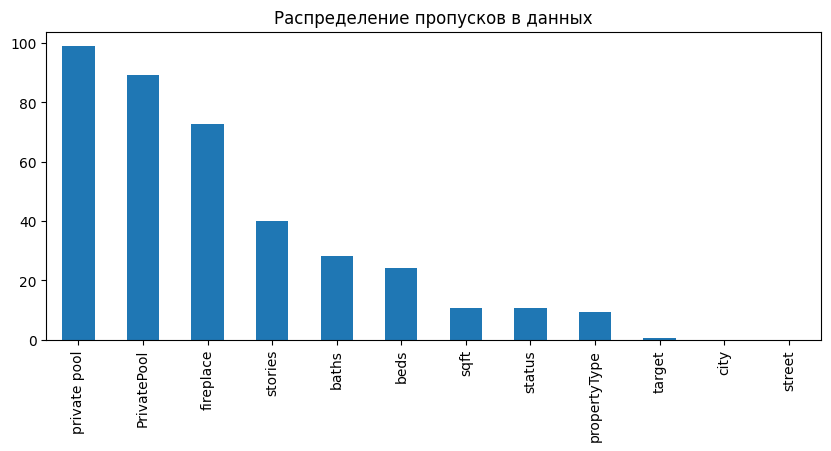

In [463]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

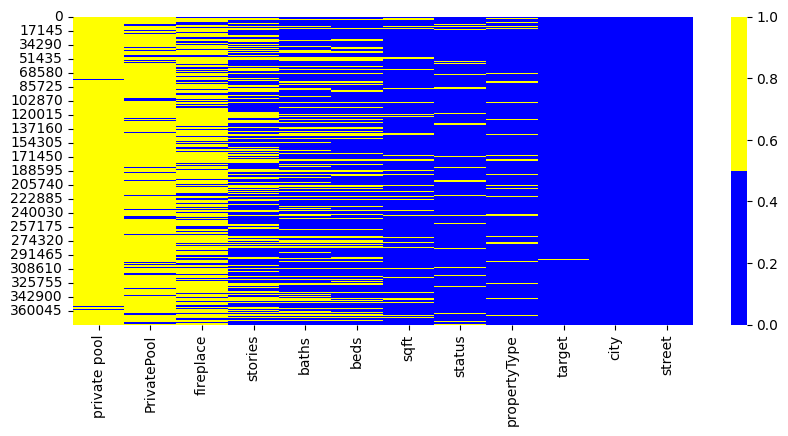

In [464]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

Очевидно, что три признака - private pool, PrivatePool, fireplace - имеют очень большое количество пропусков (более 70%). Кроме того, признаки private pool и PrivatePool несут одинаковую информацию о наличии бассейна, но даже объединив эти данные, доля пропусков все равно будет велика и их замена может исказить данные. Поэтмоу, несмотря на то, что наличие бассейна или камина могут оказывать влияние на стоимость недвижимости, эти данные придется удалить, так как восстановить их не представляется возможным.

In [465]:
# удалим все столбцы с пропусками более 40%
data = data.dropna(thresh=data.shape[0]*0.6, axis=1)

In [466]:
# найдем и удалим дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
sber_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Число найденных дубликатов: 141
Результирующее число записей: 377044


Проверим данные на неинформативные признаки, которые не играют роли при моделировании и лишь засоряют таблицу, увеличивая объем данных. Найдем признаки, в которых:
- 95% строк содержат одинаковые значения
- 95% строк содержат уникальные значения 

In [467]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
    else:
        print(f'{col} не является неинформативным признаком')

status не является неинформативным признаком
propertyType не является неинформативным признаком
street не является неинформативным признаком
baths не является неинформативным признаком
homeFacts не является неинформативным признаком
city не является неинформативным признаком
schools не является неинформативным признаком
sqft не является неинформативным признаком
zipcode не является неинформативным признаком
beds не является неинформативным признаком
state не является неинформативным признаком
stories не является неинформативным признаком
target не является неинформативным признаком


### 3. Преобразование данных и EDA.

Исследуем и преобразуем каждый признак.

Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении стимости недвижимости.

#### 3.1 Целевой признак - target.

In [468]:
# выведем статистику
data['target'].describe()

count       374704
unique       43939
top       $225,000
freq          1462
Name: target, dtype: object

In [469]:
# посмотрим на распределение
data['target'].value_counts().nlargest(15)

target
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
$375,000    1163
$450,000    1141
$499,000    1099
$175,000    1096
$425,000    1075
Name: count, dtype: int64

Признак имеет большое количество уникальных значение, что неудивительно, так как цена всегда индивидуальна для каждого объекта. 

- Проверим признак на пропуски и удалим их, так как это целевой признак, а значит строк с пропусками в нем быть не должно. 
- Проверим признак на специфические данные (возможно есть данные, не отвечающие сути признака)
- Переведем признак в тип данных float.
- Проверим и избавимся, если нужно от выбросов.

In [470]:
data['target'].isnull().mean()*100

0.6577674085660883

In [471]:
data = data.dropna(subset=['target'])

In [472]:
data[data.target.str.contains('/mo',regex=True)]

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,target
547,for rent,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,"$5,500/mo"
609,for rent,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,"$10,500/mo"
2075,for rent,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,"$6,390/mo"
3025,for rent,multi-family,411 Kline Aly,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","1,280 sqft",37040,2 Beds,TN,NaN,"$1,200/mo"
3645,for rent,multi-family,240 E Illinois St #2011,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...","1,473 sqft",60611,2 Beds,IL,NaN,"$3,600/mo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371791,for rent,multi-family,9436 Turrentine Dr,1.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",El Paso,"[{'rating': ['4/10', '8/10', '6/10'], 'data': ...","1,050 sqft",79925,2 Beds,TX,NaN,$890/mo
372459,for rent,townhouse,34 Jonquil Pl,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",The Woodlands,"[{'rating': ['5/10', '8/10', '7/10', '8/10'], ...","2,601 sqft",77375,3 Beds,TX,NaN,"$2,500/mo"
374288,for rent,single-family home,8864 Devonshire Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Fort Worth,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,000 sqft",76131,4 Beds,TX,NaN,"$2,000/mo"
375550,for rent,townhouse,2217 W Seybert St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720 sqft,19121,2 Beds,PA,NaN,"$1,500/mo"


В данных есть объекты, предназначенные для аренды, они имеют стоимость за месяц. Такие данных нужно удалить, чтобы не было путаницы между продажей и арендой.

In [473]:
data = data.drop(data[data['status'] == 'for rent'].index)

In [474]:
# удалим ненужные символы и переведем в тип данных float
data['target'] = data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', '')).astype(float)

Text(0.5, 1.0, 'Целевой признак до удаления выбросов')

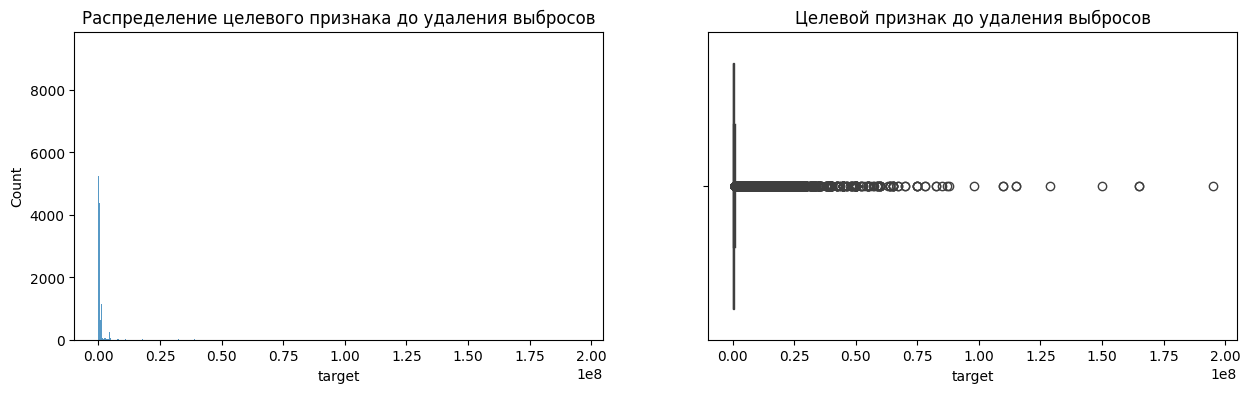

In [475]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак до удаления выбросов')

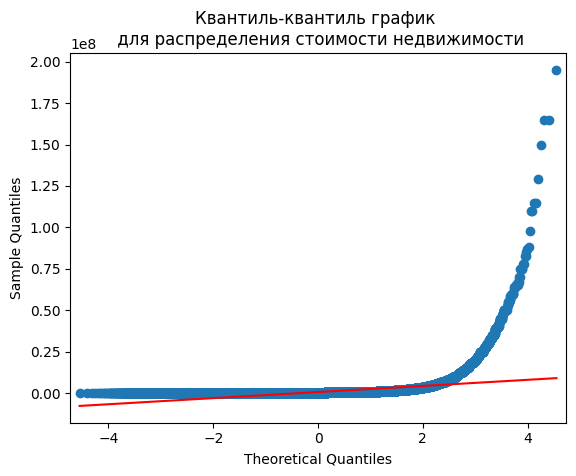

In [476]:
qqplot(data.target, line='s')
plt.title('Квантиль-квантиль график \n для распределения стоимости недвижимости')
plt.show()

Визуально распределение целевого признака не выглядит нормально. Проверим эту гипотезу с помощью статистического теста Д’Агостино (так как данных более 5000). 

H0 = 'Данные распределены нормально'

H1 = 'Данные не распределены нормально (мы отклоняем H0)'

Значение альфа - 0.5

In [477]:
alpha=0.5
_,p = stats.normaltest(data['target'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [478]:
def outliers_z_score(data, feature, log_scale=False):
    """Функция для определения выбросов в данных по методу z-отклонений и их удалению

    Args:
        data (DataFrame): таблица с данными
        feature: признак
        log_scale: параметр, отвечающий за логарифмирование (по умолчанию False)

    Returns:
        outliers: найденные выбросы
        cleaned: очищенная от выбросов таблица
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [479]:
outliers, data = outliers_z_score(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 6112
Результирующее число записей: 368194


Text(0.5, 1.0, 'Целевой признак после удаления выбросов')

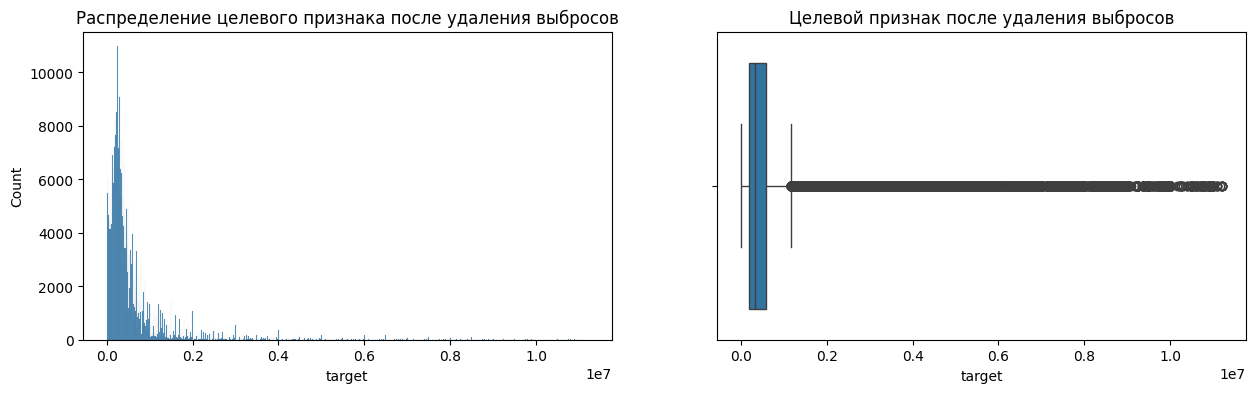

In [480]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак после удаления выбросов')

#### 3.2 Признак stories - количество этажей.

In [481]:
# выведем статистику
data['stories'].describe()

count     223369
unique       340
top          1.0
freq       66326
Name: stories, dtype: object

In [482]:
# посмотрим на распределение
data['stories'].value_counts().nlargest(15)

stories
1.0        66326
2.0        54599
1          22716
2          17869
3.0        11144
0.0         7153
One         5757
0           4204
3           4160
9.0         2905
2.00        2770
Two         2494
4.0         2111
2 Story     1970
1 Story     1253
Name: count, dtype: int64

In [483]:
# посмотрим уникальные значения
data['stories'].unique().tolist()

[nan,
 '2.0',
 '1.0',
 '3.0',
 'One',
 '2',
 'Multi/Split',
 '4.0',
 '0.0',
 '0',
 'One Level',
 '1',
 '9.0',
 '3',
 '1 Level, Site Built',
 'One Story',
 '3.00',
 '1.00',
 '14.0',
 'Two',
 '3+',
 '1 Story',
 '5.0',
 '2 Story',
 'Ranch/1 Story',
 'Condominium',
 'Stories/Levels',
 '7.0',
 '2 Level, Site Built',
 '2 Level',
 '15',
 '3 Level, Site Built',
 '4',
 '22.0',
 '2.00',
 '6.0',
 '1.0000',
 'Lot',
 '3 Story',
 'Three Or More',
 '1.5',
 '1 Level',
 'Two Story or More',
 'Site Built, Tri-Level',
 '54.0',
 '23',
 'Farm House',
 '8.0',
 '16.0',
 '1.50',
 '18',
 '9',
 '21',
 '8',
 '12.0',
 'Split Level w/ Sub',
 '11.0',
 '1.5 Stories',
 '7',
 '11',
 'Townhouse',
 '12',
 '21.0',
 '16',
 '1.5 Story/Basement',
 '28.0',
 'Traditional',
 '2.5 Story',
 '17',
 '2.0000',
 '63.0',
 'Acreage',
 'Ground Level, One',
 '6',
 'Split Foyer',
 '2 Stories',
 '27.0',
 '19.0',
 '2.50',
 '1.30',
 '2 Story/Basement',
 'Split Level',
 '1.5 Story',
 '1.5 Level',
 '2 Or More Stories',
 '1 Level, Condo, Site 

In [484]:
data['stories'].isnull().mean()*100

39.33388376779632

Значения у признака очень разные и очень многие не совсем понятные: например 3.5, 96, Multi Level, Two Story or More и т.д. Такие значения невозможно трактовать однозначно. Произвести какую-то градацию не представляется возможным, слишком много значений, которые будет сложно отнести к какой-то группе. Кроме того в признаке почти 40% пропусков, удалим этотм признак.

In [485]:
data = data.drop('stories', axis =1)

In [486]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368194 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        329228 non-null  object 
 1   propertyType  334587 non-null  object 
 2   street        368192 non-null  object 
 3   baths         266798 non-null  object 
 4   homeFacts     368194 non-null  object 
 5   city          368165 non-null  object 
 6   schools       368194 non-null  object 
 7   sqft          330605 non-null  object 
 8   zipcode       368194 non-null  object 
 9   beds          280991 non-null  object 
 10  state         368194 non-null  object 
 11  target        368194 non-null  float64
dtypes: float64(1), object(11)
memory usage: 36.5+ MB


#### 3.3 Признаки zipcode - почтовый индекс и  street - адрес объекта.

Несомненно эти признаки сильно коррелируют друг с другом, так как индекс привязан к адресу. Поэтому признак индекс удалим.

In [487]:
data = data.drop('zipcode', axis =1)

In [488]:
# выведем статистику
data['street'].describe()

count                    368192
unique                   328699
top       Address Not Disclosed
freq                        670
Name: street, dtype: object

In [489]:
# посмотрим на распределение
data['street'].value_counts().nlargest(15)

street
Address Not Disclosed         670
Undisclosed Address           512
(undisclosed Address)         386
Address Not Available         174
Unknown Address                72
2103 E State Hwy 21            57
11305 Gulf Fwy                 54
17030 Youngblood Rd.           38
NE 58th Cir                    34
9470 Lancaster Rd. SW          32
1 Palmer Dr                    27
8426 Terrace Valley Circle     25
9845 Basil Western Rd NW       25
6320 SW 89th Court Road        24
8447 SW 99th Street Rd         22
Name: count, dtype: int64

Признак street имеет много уникальных значений, что неудивительно, так как у каждого объекта свой адрес. 

In [490]:
# проверим признак на пропуски
data['street'].isnull().mean()*100

0.0005431919042678588

Так как признак категориальный, заменим небольшое количество пропусков модой.

In [491]:
data['street'] = data['street'].fillna(data['street'].mode()[0])

Извлечем из адреса типы улиц (бульвар, проспект, площадь и т.д.), так как расположение дома на определенных типах улицы может влиять на его стоимость и это придаст структуру данным. 

In [492]:
data['street'] = data['street'].astype(str)
data['street'] = data['street'].str.lower()
# удалим ненужные символы
data['street'] = data['street'].apply(lambda x: str(x).replace('(', '').replace(')', ''))

In [493]:
def get_type_of_street(street):
    """Функция для извлечения типа улицы из адреса

    Args:
        street: признак с адресом

    Returns:
        str: тип улицы
    """
    for type in street:
        if street is np.nan:
            return np.nan
        elif 'address not disclosed' in street or 'undisclosed address' in street:
            return 'undisclosed'
        elif 'address not available' in street:
            return 'not available'
        elif 'unknown address' in street:
            return 'unkown'
        elif 'parkway' in street or 'prwy' in street:
            return 'prwy'
        elif 'boulevard' in street or 'blw' in street or'blwd' in street:
            return 'blw'
        elif 'railway' in street or 'rw' in street or'rwy' in street:
            return 'rwy'
        elif 'quay' in street or 'qy' in street:
            return 'qy'
        elif 'lane' in street or 'ln' in street:
            return 'ln'
        elif 'square' in street or 'sq' in street:
            return 'sq'
        elif 'place' in street or 'pl' in street:
            return 'pl'
        elif 'drive' in street or 'dr' in street:
            return 'dr'
        elif 'avenue' in street or 'ave' in street:
            return 'ave'
        elif 'terrace' in street or 'tce' in street:
            return 'tce'
        elif 'street' in street or 'st' in street:
            return 'st'
        elif 'hill' in street or 'hl' in street:
            return 'hl'
        elif 'road' in street or 'rd' in street:
            return 'rd'
        elif 'highway' in street or 'hwy' in street:
            return 'hwy'
        else:
            return 'unkown'

In [494]:
data['street'] = data['street'].apply(get_type_of_street)

In [495]:
data_street = data.groupby('street')['street'].value_counts()
data_street = data_street.sort_values(ascending=False)

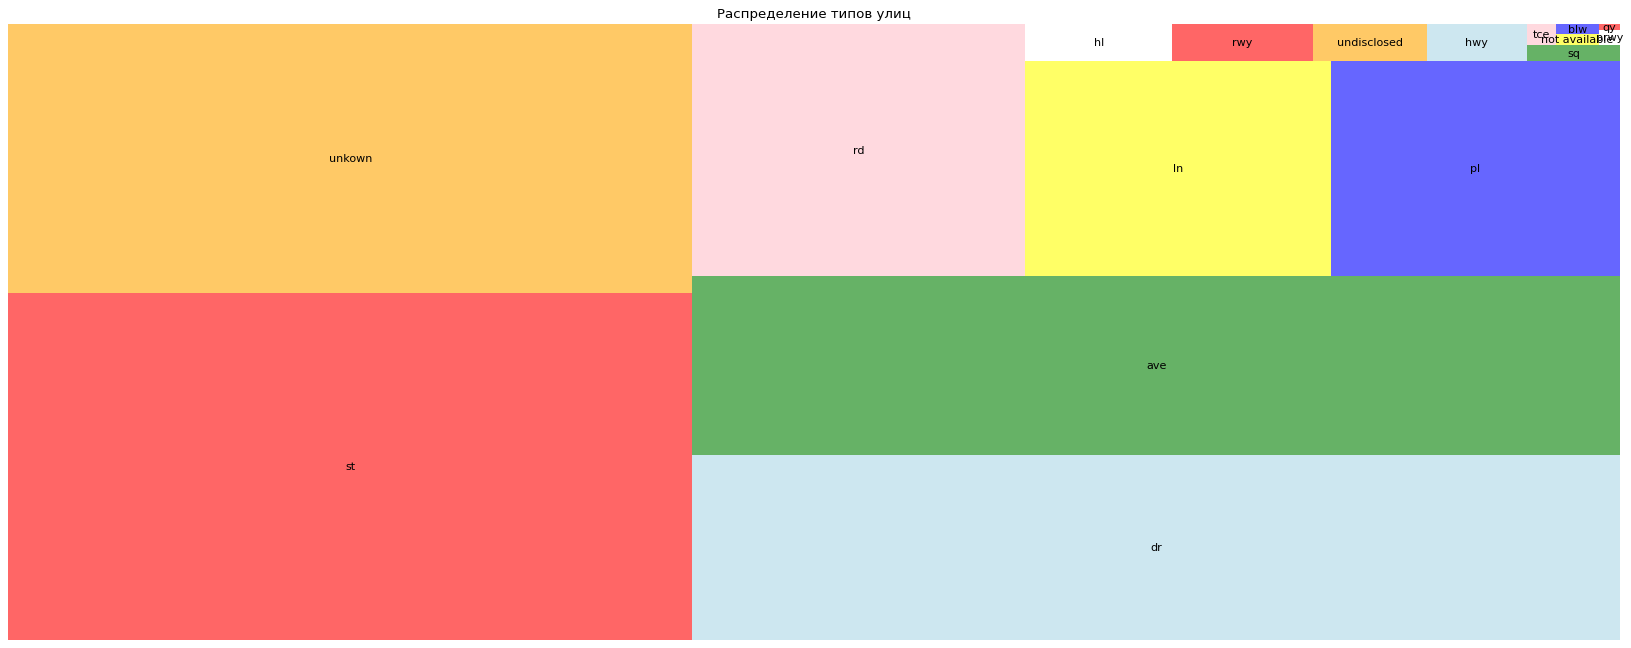

In [496]:
# строим древовидную диаграмму с рапределением стран проживания среди специалистов DS
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_street.values, label = data_street.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Распределение типов улиц')
plt.axis('off')
plt.show()

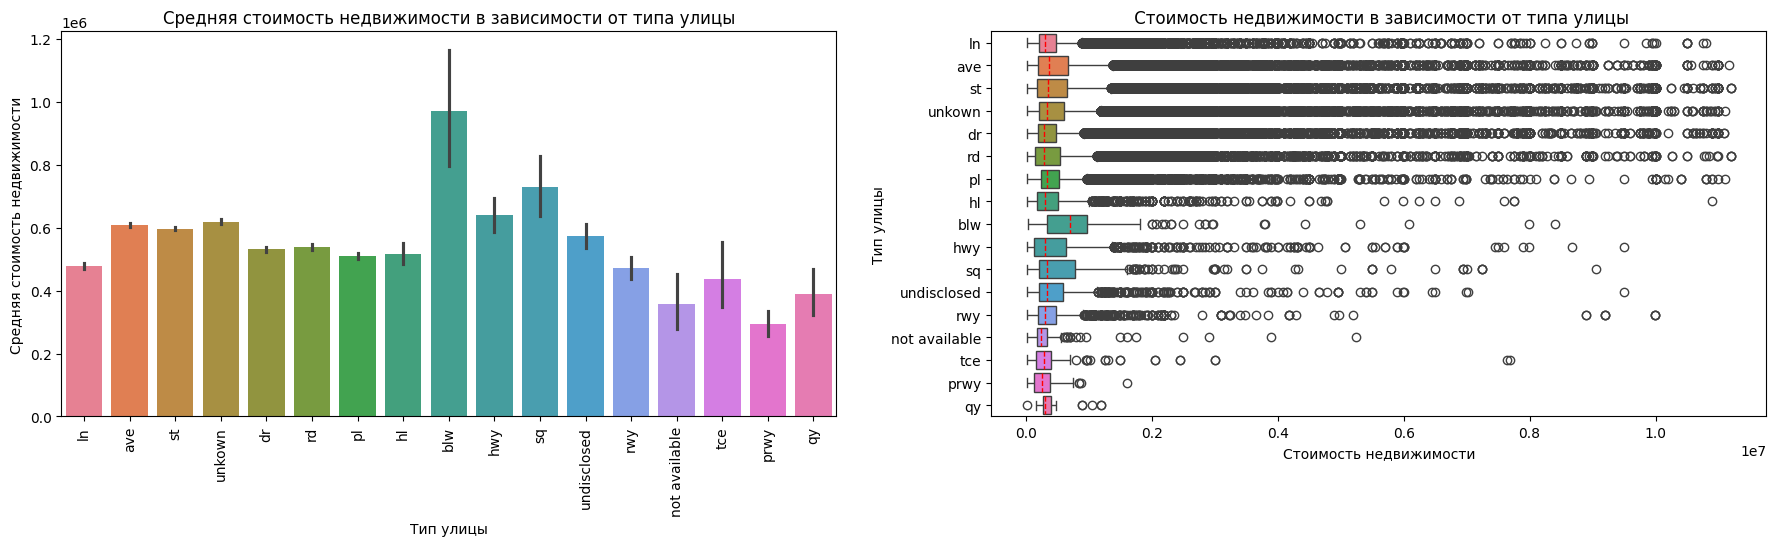

In [497]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа улицы
sns.barplot(
            data, 
            x='street', 
            y='target', 
            hue='street', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип улицы', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа улицы')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа улицы
sns.boxplot(
            data, 
            x='target', 
            y='street', 
            orient='h', 
            hue='street',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип улицы')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа улицы')

plt.show()

Большинство адресов находятся на улицах, проспектах, проездах, а так же неизвестно. Самая высокая средняя стоимость у недвижимости, которая находится на бульварах и площадях. Самая низкая средняя стоимость у недвижимости, которая находится на тех типах улиц, что встречаются реже всего в данных - аллеи, набарежные и недостыпные адреса. Возможно это связано с маленьким количеством данных в этих категориях. Коробчатая диаграмма показывает, что медианная цена недвижимости, распложенной на бульварах выше, чем у других категорий. Расположение недвижимости на определенных типах улиц влияет на ее стоимость.

Закодируем признак street однократным кодированием (признак номинальный, количество значений не велико)

In [498]:
encoder = ce.OneHotEncoder(cols = ['street'], use_cat_names=True)
street_bin = encoder.fit_transform(data['street'])
data = pd.concat([data, street_bin], axis=1)

In [499]:
data = data.drop('street', axis = 1)

In [500]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368194 entries, 0 to 377184
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                329228 non-null  object 
 1   propertyType          334587 non-null  object 
 2   baths                 266798 non-null  object 
 3   homeFacts             368194 non-null  object 
 4   city                  368165 non-null  object 
 5   schools               368194 non-null  object 
 6   sqft                  330605 non-null  object 
 7   beds                  280991 non-null  object 
 8   state                 368194 non-null  object 
 9   target                368194 non-null  float64
 10  street_ln             368194 non-null  int64  
 11  street_ave            368194 non-null  int64  
 12  street_st             368194 non-null  int64  
 13  street_unkown         368194 non-null  int64  
 14  street_dr             368194 non-null  int64  
 15  stree

#### 3.4 Признаки state - штат и  city - город.

Как и в паре индекс-адрес, признаки штат и город сильно коррелируют друг с другом, так как определенные города расположены в определенных штатах. Оставлять оба признака не имеет смысла. Удалим признак state.

In [501]:
data = data.drop('state', axis=1)

In [502]:
# выведем статистику
data['city'].describe()

count      368165
unique       2008
top       Houston
freq        24366
Name: city, dtype: object

In [503]:
# посмотрим на распределение
data['city'].value_counts().nlargest(20)

city
Houston            24366
San Antonio        15478
Miami              15294
Jacksonville        9820
Dallas              8721
Brooklyn            7231
Chicago             6806
Charlotte           6516
New York            6332
Las Vegas           5948
Fort Worth          5474
Orlando             5147
Austin              5120
Fort Lauderdale     5025
Nashville           4977
Cleveland           4960
Philadelphia        4744
Tampa               4696
Washington          4569
Los Angeles         4027
Name: count, dtype: int64

In [504]:
data['city'].isnull().mean()*100

0.007876282611883953

Признак категориальный, заменим пропуски модой.

In [505]:
data['city'] = data['city'].fillna(data['city'].mode()[0])

Оставить все значения городов будет очень ресурсозатратно, поэтому выделим 20 наиболее часто встречающихся, остальные заменим на 'other'.

In [506]:
popular_city = data['city'].value_counts().nlargest(20).index
data['city'] = data['city'].apply(lambda x: x if x in popular_city else 'other')

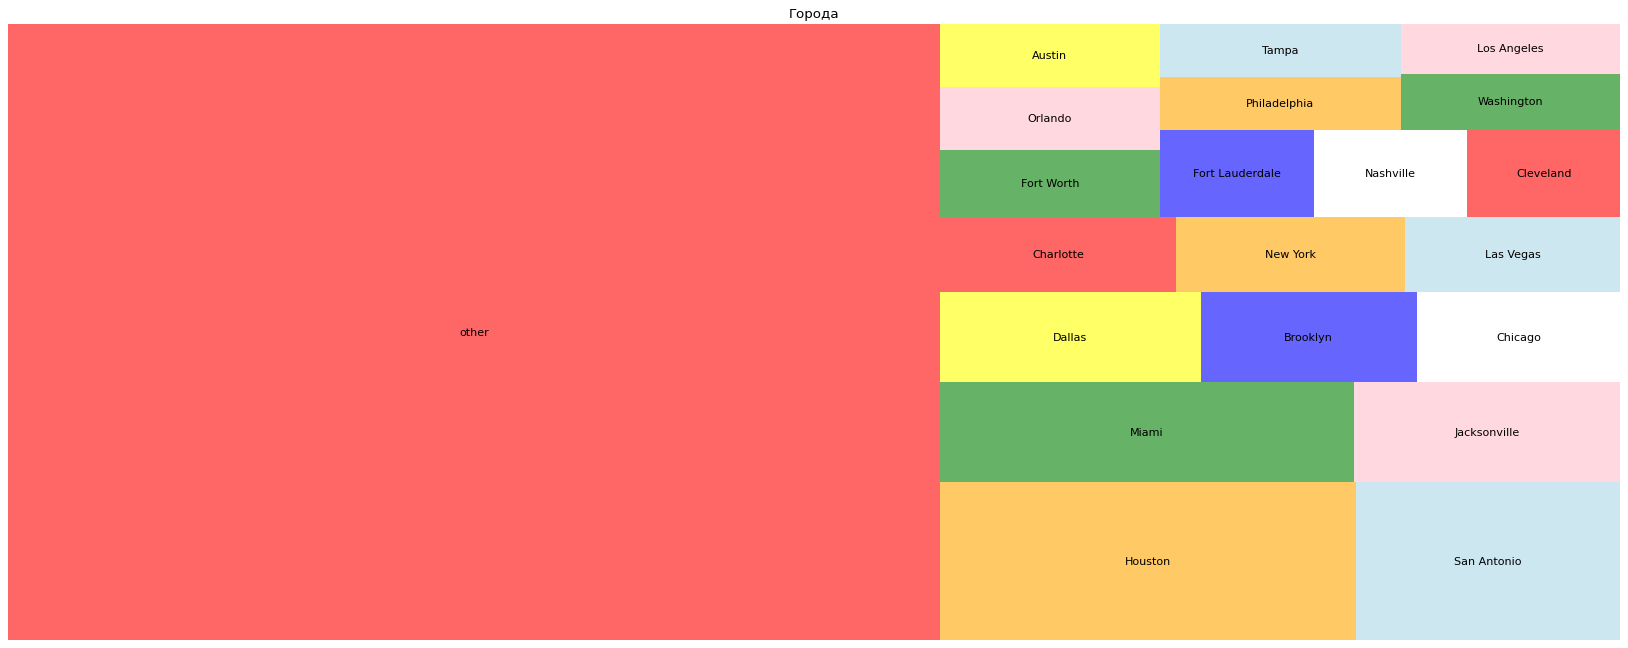

In [507]:
data_city = data.groupby('city')['city'].value_counts()
data_city = data_city.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением городов, в которях находится недвижимость
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_city.values, label = data_city.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Города')
plt.axis('off')
plt.show()

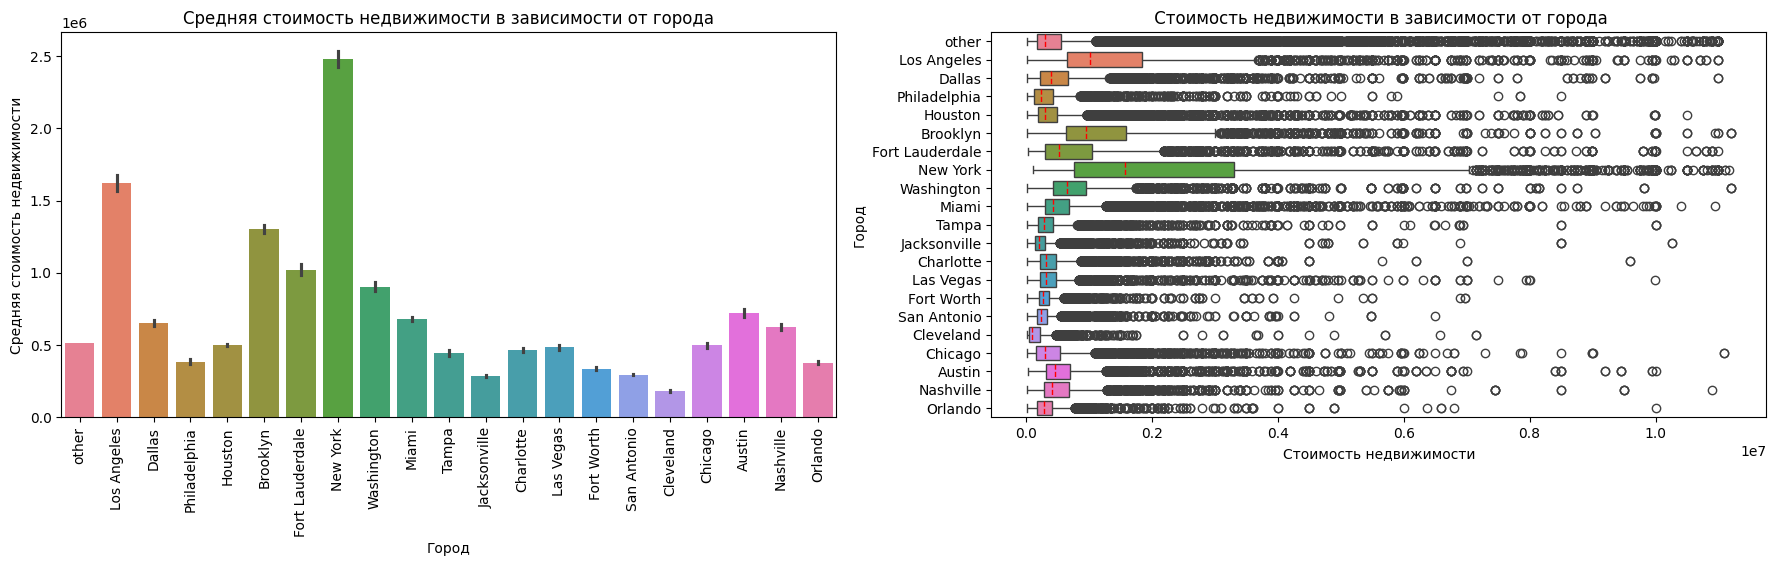

In [508]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от города
sns.barplot(
            data, 
            x='city', 
            y='target', 
            hue='city', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Город', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от города')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от города
sns.boxplot(
            data, 
            x='target', 
            y='city', 
            orient='h', 
            hue='city',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Город')
axes[1].set_title(' Стоимость недвижимости в зависимости от города')

plt.show()

Очевидно, что самая высокая средняя стоимость недвижимости будет в самых крупных и дорогих городах - Нью-Йорке и Лос-Анджелесе. Медианная цена также намного выше в этих городах, а также Бруклине (это часть Нью-Йорка), Вашингтоне (столице) и Форт-Лодердейл (город на юго-восточном побережье Флориды, который славится своими пляжами и каналами, популярными у любителей прогулок на яхтах, дорогими ресторанами и отелями). Расположение недвижимости в определенном городе влияет на его цену и разница может доходть до сотен процентов.

Закодируем признак city однократным кодированием (признак номинальный, количество значений не велико)

In [509]:
encoder = ce.OneHotEncoder(cols = ['city'], use_cat_names=True)
city_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, city_bin], axis=1)

In [510]:
data = data.drop('city', axis = 1)

#### 3.5 Признак beds - количество спален.

In [511]:
# выведем статистику
data['beds'].describe()

count     280991
unique      1119
top       3 Beds
freq       52331
Name: beds, dtype: object

In [512]:
# посмотрим на распределение
data['beds'].value_counts().nlargest(15)

beds
3 Beds    52331
4 Beds    34825
3         31140
2 Beds    25880
4         19816
2         15970
Baths     15212
3 bd      12661
5 Beds    11060
4 bd       8176
3.0        8078
5          6286
4.0        5228
2 bd       5154
1          4570
Name: count, dtype: int64

In [513]:
data['beds'].isnull().mean()*100

23.683981813935045

In [514]:
data['beds'].unique().tolist()

['4',
 '3 Beds',
 '5 Beds',
 '2 Beds',
 nan,
 '3',
 '4 Beds',
 '3 bd',
 'Baths',
 '4 bd',
 '5 bd',
 '8 Beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 Beds',
 'Bath',
 '12 Beds',
 '6',
 '14',
 '0.25 acres',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '1 bd',
 '9 Beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '7 Beds',
 '0.32 acres',
 '8,637 sqft',
 '6 bd',
 '7.0',
 '16 Beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '8',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '10 Beds',
 '0.46 acres',
 '0.59 acres',
 '20 Beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 Beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 '8,189 sqft',
 '1.04 acres'

Одна и таже информация о количестве спален записана в разных форматах, по сути нам нужна только цифра. Кроме того есть строки со значением площади в футах (1435 строк) и акрах(1640 строк), как их интерпретировать не ясно, заменим их на np.nan, так как их общее количество менее 1%. Далее оставим только цифру, заменим пропуски на моду, проверим и очистим данные от выбросов.

In [515]:
# заменяем на np.nan строки с площадью
data['beds'] = data['beds'].fillna('unkown')
data['beds'] = data['beds'].apply(lambda x: np.nan if 'sqft' in x or 'acr' in x or 'unkown' in x else x)
# оставляем только числа
data['beds'] = data['beds'].str.replace(r"[^\d\.]", "", regex=True)
data['beds'] = data['beds'].apply(lambda x: str(x).replace('.', '') if  str(x).endswith('.') else x)
data['beds'] = data['beds'].apply(lambda x: np.nan if  x == '' else x)

Не смотря на то, что по сути получается числовой признак, считаю, что пропуски нужно заменить модой - как самое часто встречающееся количество спален.

In [516]:
data['beds'] = data['beds'].fillna(data['beds'].mode()[0])
data['beds'] = data['beds'].astype(float)
data['beds'] = data['beds'].astype(int)

Text(0.5, 1.0, 'Признак beds до удаления выбросов')

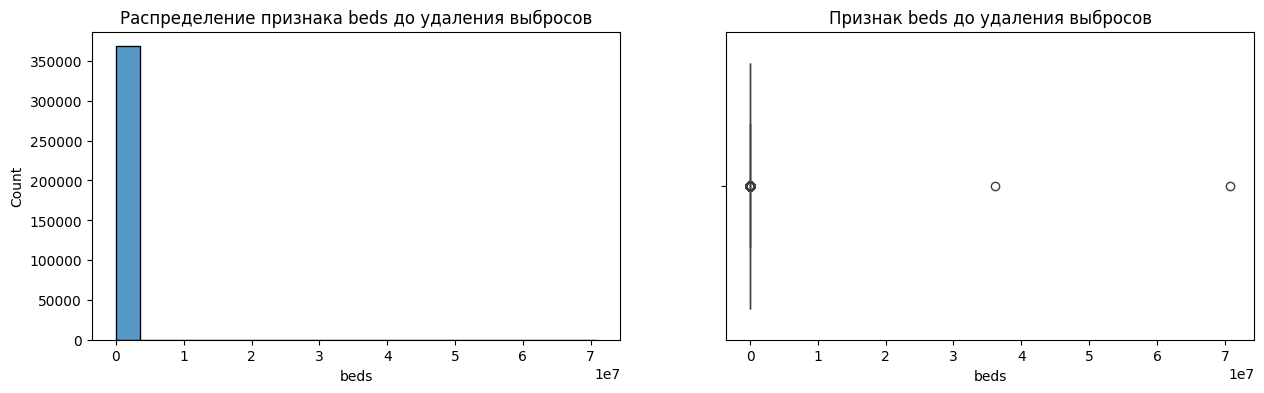

In [517]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'beds', bins=20, ax = axes[0]);
histplot.set_title('Распределение признака beds до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'beds', ax = axes[1])
boxplot.set_title('Признак beds до удаления выбросов')

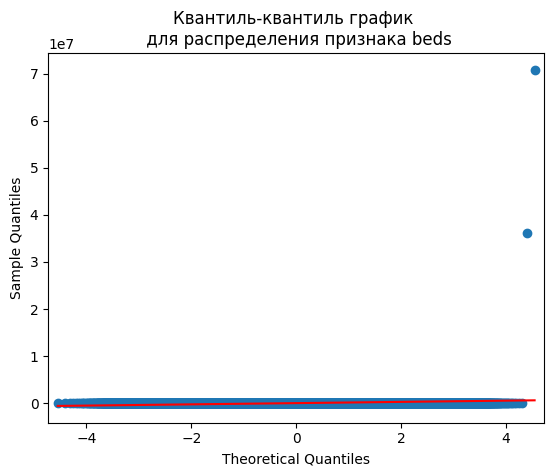

In [518]:
qqplot(data.beds, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака beds')
plt.show()

Визуально не удается определить нормально ли распределение, но выбросы точно есть. Используем тест Д'Агостино для проверки распределения на нормальность.

In [519]:
alpha=0.5
_,p = stats.normaltest(data['beds'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [520]:
outliers, data = outliers_z_score(data, 'beds', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 3989
Результирующее число записей: 364205


In [521]:
data['beds'].unique().tolist()

[4, 3, 5, 2, 1, 6, 7]

Text(0.5, 1.0, 'Признак beds после удаления выбросов')

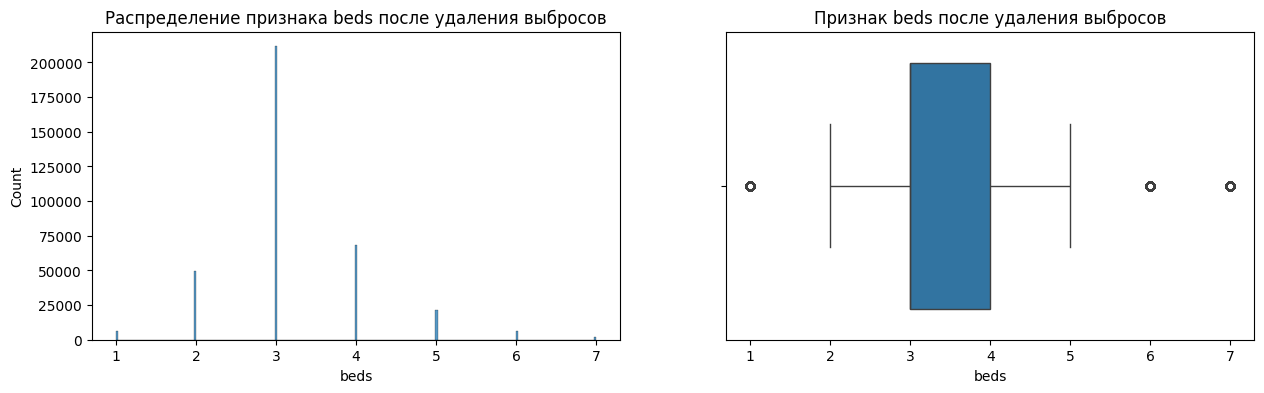

In [522]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'beds', ax = axes[0]);
histplot.set_title('Распределение признака beds после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'beds', ax = axes[1])
boxplot.set_title('Признак beds после удаления выбросов')

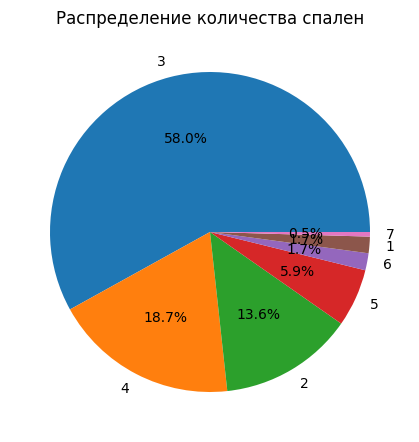

In [523]:
# визуализируем распределение недвижимости по количеству спален
beds_count = data['beds'].value_counts()
fig = plt.figure(figsize = (4,4))
axes = fig.add_axes([0,0,1,1])
axes.pie(beds_count, labels = beds_count.index, autopct = '%.1f%%')
axes.set_title('Распределение количества спален');

Text(0.5, 1.0, ' Стоимость недвижимости в зависимости от количества спален')

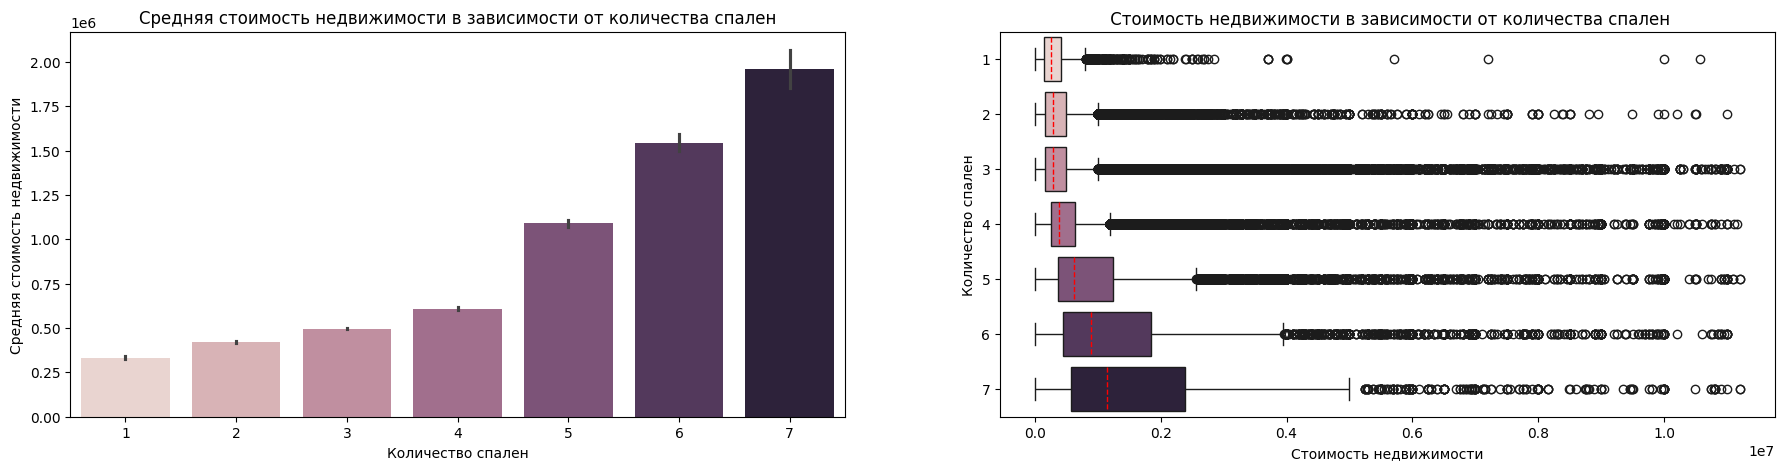

In [524]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от количества спален
sns.barplot(
            data, 
            x='beds', 
            y='target', 
            hue='beds', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Количество спален', ylabel='Средняя стоимость недвижимости')
axes[0].set_title('Средняя стоимость недвижимости в зависимости от количества спален')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от количества спален
sns.boxplot(
            data, 
            x='target', 
            y='beds', 
            orient='h', 
            hue='beds',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Количество спален')
axes[1].set_title(' Стоимость недвижимости в зависимости от количества спален')

Наиболшее количество объектов недвижимости имеют от 2 до 4 спален. Средняя стоимость недвижимости возрастает с увеличением количества спален, что логично, чем больше спален, тем больше площадь дома и соответственно его цена. Тоже самое можно сказать про медианную цену. Объекты, в которых до 3-х спален, имеют близкую медианную цену, а начиная с объектов с 4-мя спальнями медианная цена постепенно увличивается. От количества спален цена объекта определенно зависит.

#### 3.6 Признак baths - количество ванных комнат.

In [525]:
# выведем статистику
data['baths'].describe()

count      263682
unique        169
top       2 Baths
freq        51622
Name: baths, dtype: object

In [526]:
# посмотрим на распределение
data['baths'].value_counts().nlargest(15)

baths
2 Baths         51622
3 Baths         35115
2               20399
2.0             16305
4 Baths         14303
3.0             10763
3               10063
Bathrooms: 2     9394
2.5              8110
Bathrooms: 3     6544
1                6363
1.0              5466
5 Baths          5070
4.0              4494
2.5 Baths        4386
Name: count, dtype: int64

In [527]:
data['baths'].isnull().mean()*100

27.600664460949194

In [528]:
data['baths'].unique().tolist()

['3.5',
 '3 Baths',
 '2 Baths',
 '8 Baths',
 nan,
 '2',
 '3',
 'Bathrooms: 2',
 '1,750',
 '4 Baths',
 '2 ba',
 'Bathrooms: 5',
 '1,000',
 '2.0',
 '3.0',
 'Bathrooms: 1',
 '4.0',
 '2.1 Baths',
 '2.5 Baths',
 '1',
 'Bathrooms: 3',
 '4.5',
 '6 Baths',
 'Bathrooms: 4',
 '3 ba',
 '5',
 '2,500',
 '5.5 Baths',
 '1.0',
 '5 Baths',
 '1.5',
 '4',
 '~',
 '2.5',
 '4,000',
 '3.5 Baths',
 '2,000',
 '3,000',
 '1 ba',
 '0',
 '5.0',
 '1,500',
 '7.0',
 '1,250',
 '9 Baths',
 '2,250',
 '6.0',
 '5.5',
 '7 Baths',
 '3,500',
 '1.5 Baths',
 '2,750',
 'Bathrooms: 6',
 '4.5 Baths',
 '750',
 '5.5+',
 '6',
 '6 ba',
 '10 Baths',
 '4 ba',
 '12 ba',
 '2.5+',
 '8',
 '7.5+',
 '0 / 0',
 'Sq. Ft. ',
 '8.0',
 '5 ba',
 '-- baths',
 'Bathrooms: 7',
 '7',
 '3.5+',
 '1.5+',
 '11 Baths',
 '5,000',
 '1.75 Baths',
 '10.0',
 'Bathrooms: 10',
 '12.0',
 '6.5',
 'Bathrooms: 8',
 '4.5+',
 '19 Baths',
 'Bathrooms: 9',
 '13 Baths',
 '9.0',
 '8.5+',
 '7 ba',
 '1.1 Baths',
 '2.5 ba',
 '12 Baths',
 'Bathrooms: 241',
 '9',
 '10',
 '6.5+',

Признак baths похож по содержанию на признак beds, информация записана в разном формате. По сути нам нужна только цифра. Пропуски как и в случае с beds заменим на моду - как самый часто встречающийся вариант с ванными комнатами. Проверим и очистим признак от выбросов. Так же хочется обратить внимание на дробные значения.Типы ванных комнат определяются на основе того, какие из четырех основных приборов для ванной комнаты включены: унитаз, раковина, ванна и душ. Полноценной считается ванная комната с туалетом, раковиной и ванной/душевой кабиной, а помещение, где есть только туалет и раковина — это 0.5 ванной комнаты. Ванная комната на три четверти будет иметь три из четырех ключевых компонентов. Чаще всего такие комнаты будут включать туалет, раковину и душевую кабину без ванны.

In [529]:
# оставляем только числа
data['baths'] = data['baths'].apply(lambda x: np.nan if '/' in str(x) else x)
data['baths'] = data['baths'].str.replace(r"[^\d\.]", "", regex=True)
data['baths'] = data['baths'].apply(lambda x: np.nan if  x == '..' or x == '' else x)

In [530]:
data['baths'] = data['baths'].fillna(data['baths'].mode()[0])

In [531]:
data['baths'] = data['baths'].astype(float)

Text(0.5, 1.0, 'Признак baths до удаления выбросов')

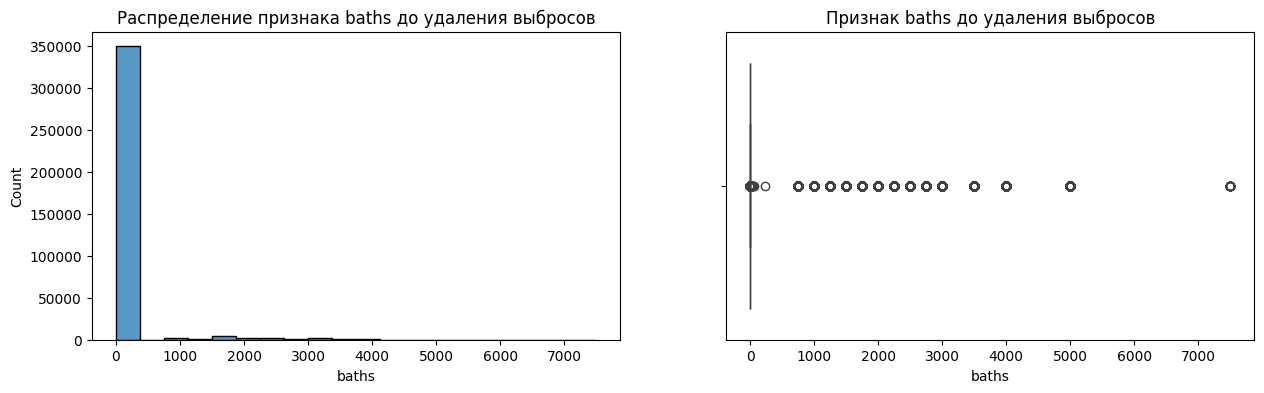

In [532]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'baths', bins=20, ax = axes[0]);
histplot.set_title('Распределение признака baths до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'baths', ax = axes[1])
boxplot.set_title('Признак baths до удаления выбросов')

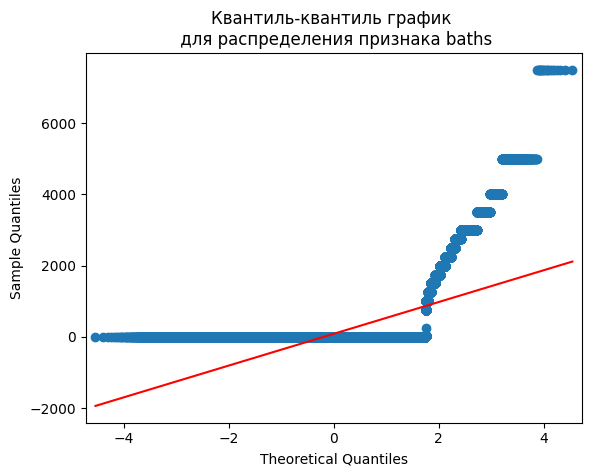

In [533]:
qqplot(data.baths, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака baths')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [534]:
alpha=0.5
_,p = stats.normaltest(data['baths'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [535]:
outliers, data = outliers_z_score(data, 'baths', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 14573
Результирующее число записей: 349632


In [536]:
data['baths'].describe()

count    349632.000000
mean          2.499686
std           1.091293
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          60.000000
Name: baths, dtype: float64

Text(0.5, 1.0, 'Признак baths после удаления выбросов')

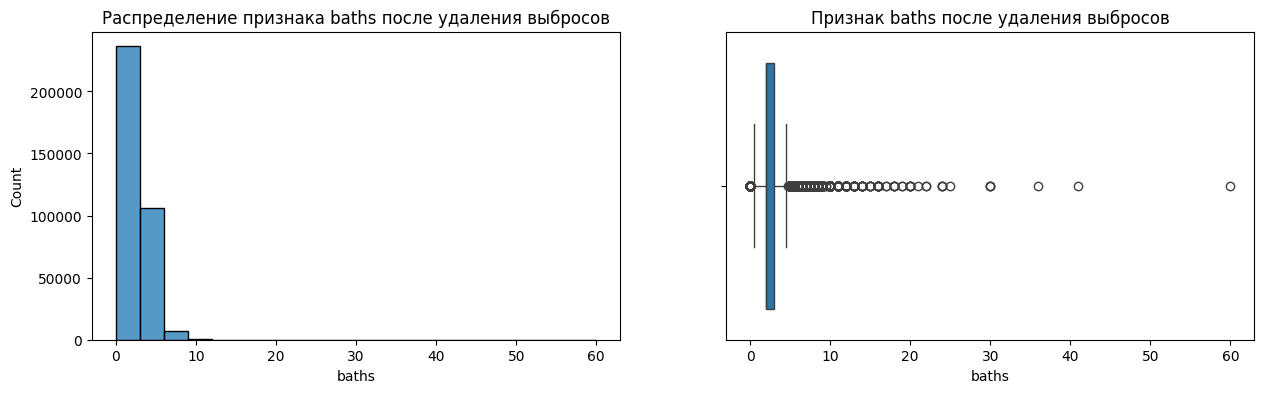

In [537]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'baths', bins = 20, ax = axes[0]);
histplot.set_title('Распределение признака baths после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'baths', ax = axes[1])
boxplot.set_title('Признак baths после удаления выбросов')

Даже после удаления выбросов кажутся не совсем реальными объекты недвижимости с более чем 20-ю ванными комнатами. Удалим такие строки.

In [538]:
data = data.drop(data[data['baths']>=20].index)

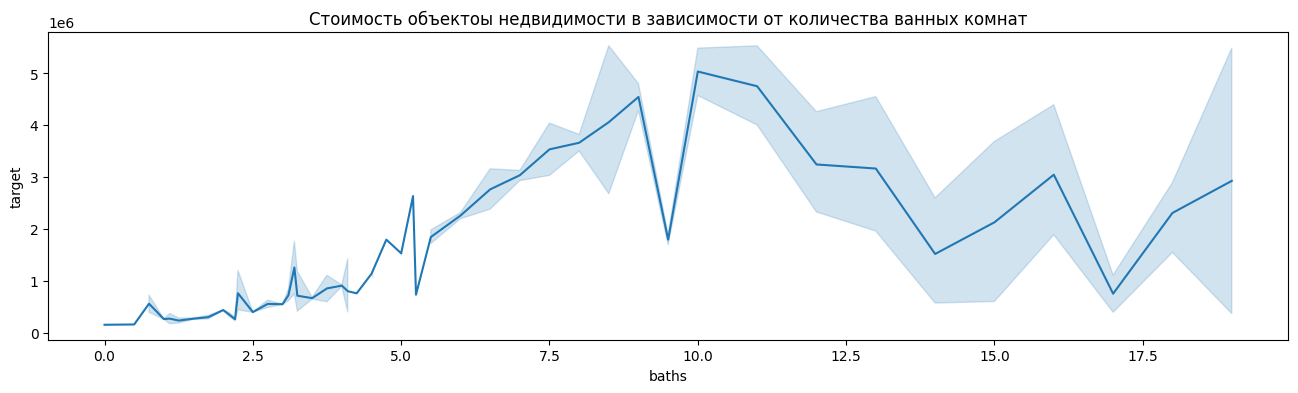

In [539]:
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=data, x="baths", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от количества ванных комнат');

Text(0.5, 1.0, ' Стоимость недвижимости в зависимости от количества ванных комнат')

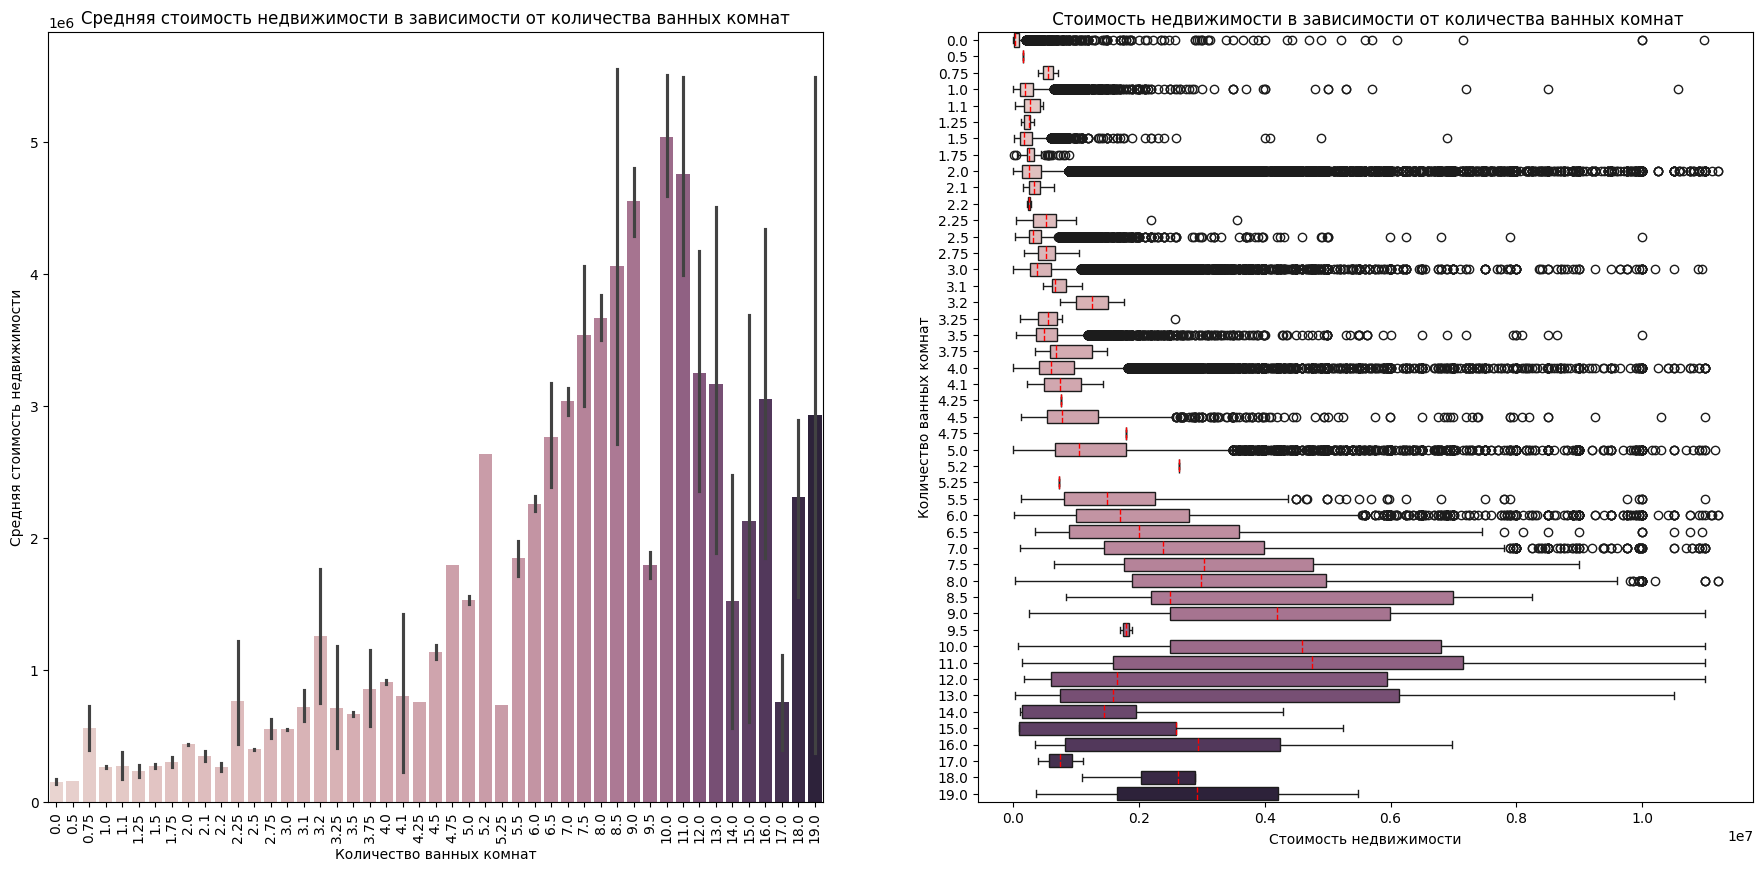

In [540]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от количества ванных комнат
sns.barplot(
            data, 
            x='baths', 
            y='target', 
            hue='baths', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Количество ванных комнат', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от количества ванных комнат')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от количества ванных комнат
sns.boxplot(
            data, 
            x='target', 
            y='baths', 
            orient='h', 
            hue='baths',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Количество ванных комнат')
axes[1].set_title(' Стоимость недвижимости в зависимости от количества ванных комнат')

Визуализации говорят о том, что средняя и медианная стоимость недвижимости растет с ростом количества ванных комнат до 11. Провал в цене случается на значениях 5.25 и 9.5, видимо потому что, таких объектов мало (один). Далее средняя и медианная цены снижаются, скорее всего недвижимость с очень большим количеством спален - достаточно специфическая и не пользуется популярностью. Количество ванных комнат влияет на стоимость недвижимости и отличаться стоимость может в разы.

#### 3.7 Признак sqft - площадь в футах.

In [541]:
# выведем статистику
data['sqft'].describe()

count     313892
unique     24130
top            0
freq       10421
Name: sqft, dtype: object

In [542]:
# посмотрим на распределение
data['sqft'].value_counts().nlargest(15)

sqft
0             10421
1,200 sqft      801
1,000 sqft      622
1,100 sqft      555
1,800 sqft      548
1,500 sqft      528
1,400 sqft      507
2,000 sqft      507
--              487
1,600 sqft      442
800 sqft        439
900 sqft        396
1,300 sqft      395
1,440 sqft      366
2,400 sqft      351
Name: count, dtype: int64

In [543]:
data['sqft'].unique().tolist()

['2900',
 '1,947 sqft',
 '3,000 sqft',
 '6,457 sqft',
 '897 sqft',
 '1,507',
 nan,
 '3588',
 '1,930',
 '1,300 sqft',
 '3,130',
 '2,839 sqft',
 'Total interior livable area: 1,820 sqft',
 '2,454',
 '3,325',
 '3,080 sqft',
 '1,612 sqft',
 '1,731 sqft',
 'Total interior livable area: 5,266 sqft',
 '3,645 sqft',
 '1,953 sqft',
 '2,575 sqft',
 '2,349 sqft',
 '935 sqft',
 '1736',
 'Total interior livable area: 1,677 sqft',
 '1,176 sqft',
 '1,085',
 '864 sqft',
 '900 sqft',
 '1,448 sqft',
 '1,396',
 'Total interior livable area: 1,232 sqft',
 '1,720 sqft',
 '2,388 sqft',
 '1,081 sqft',
 '1101',
 'Total interior livable area: 5,358 sqft',
 '1,683 sqft',
 '0',
 '1,200 sqft',
 '1,873',
 '1,908 sqft',
 '1,632 sqft',
 '4339',
 '1,681 sqft',
 '3,756 sqft',
 '1,504 sqft',
 '2,088 sqft',
 '1,076 sqft',
 '2,688',
 '1308',
 '2,200 sqft',
 '1,244 sqft',
 '2272',
 '770 sqft',
 '1,160',
 '3,928 sqft',
 'Total interior livable area: 2,383 sqft',
 '5131',
 '4,520 sqft',
 '1,250 sqft',
 '1,060 sqft',
 '538',

In [544]:
data['sqft'].isnull().mean()*100

10.217554216936394

Площадь объектов в футах представлена в виде строк, в которых указана или только цифра площади или цифра с описанием. Оставляем только цифры, пропуски заменим на медиану, т.к. она менее чувствительна к выбросам. Проверим и очистим признак от выбросов. Площадь несомненно важный, один из ключевых признаков, влияющих на стоимость.

In [545]:
data['sqft'] = data['sqft'].str.replace(r"[^\d\.]", "", regex=True)
data['sqft'] = data['sqft'].apply(lambda x: np.nan if  x == '--' or x ==  '' else x)

In [546]:
data['sqft'] = data['sqft'].fillna(data['sqft'].median())

In [547]:
data['sqft'] = data['sqft'].astype(int)

Text(0.5, 1.0, 'Признак sqft до удаления выбросов')

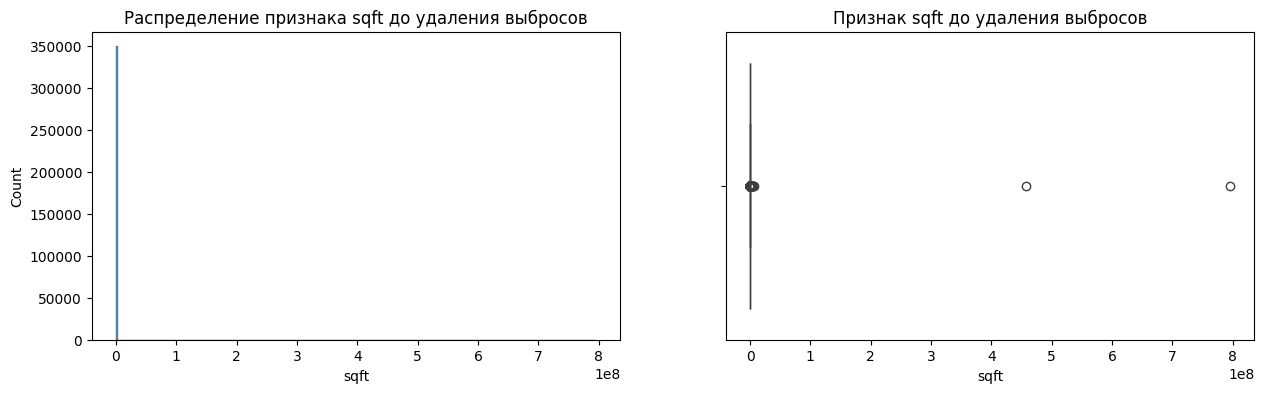

In [548]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'sqft', bins = 200, ax = axes[0]);
histplot.set_title('Распределение признака sqft до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'sqft', ax = axes[1])
boxplot.set_title('Признак sqft до удаления выбросов')

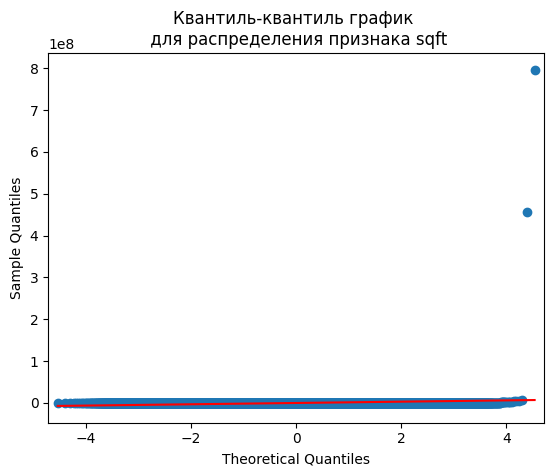

In [549]:
qqplot(data.sqft, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака sqft')
plt.show()

In [550]:
alpha=0.5
_,p = stats.normaltest(data['sqft'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [551]:
outliers, data = outliers_z_score(data, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 11204
Результирующее число записей: 338410


Text(0.5, 1.0, 'Признак sqft после удаления выбросов')

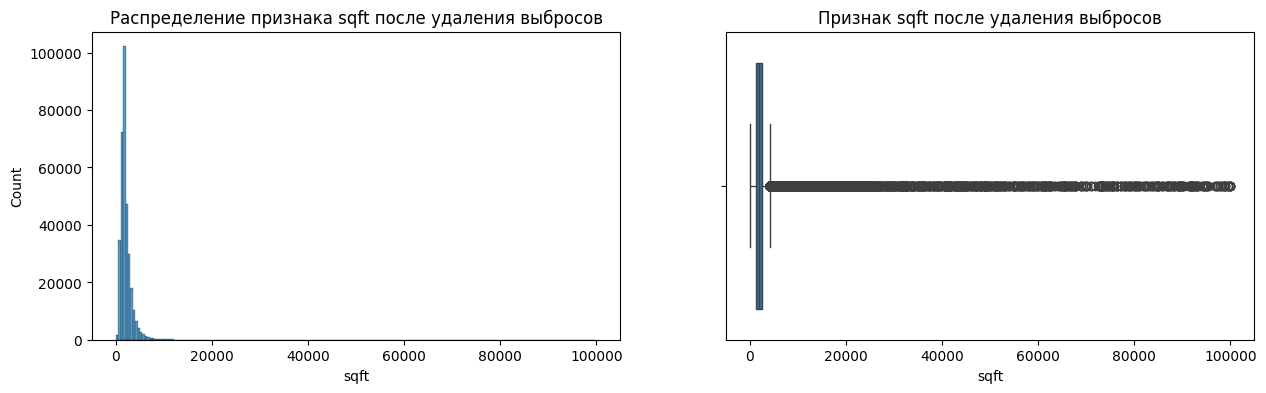

In [552]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'sqft', bins = 200, ax = axes[0]);
histplot.set_title('Распределение признака sqft после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'sqft', ax = axes[1])
boxplot.set_title('Признак sqft после удаления выбросов')

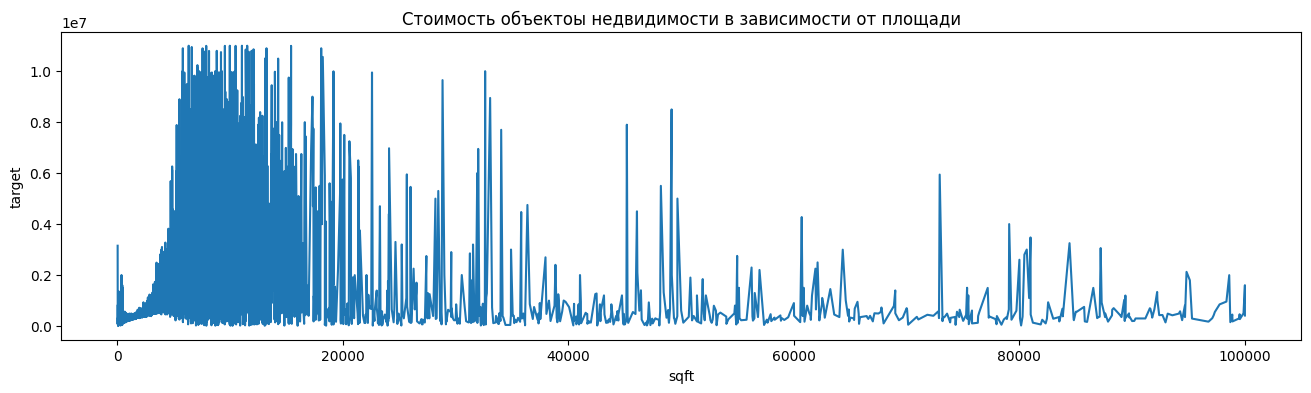

In [553]:
line_data = data.groupby('sqft', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=line_data, x="sqft", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от площади');

Определенной зависимости цены от площади не прослеживается. Все же на стоимость недвижимости влияет несколько ее характеристик.

In [554]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                300145 non-null  object 
 1   propertyType          310283 non-null  object 
 2   baths                 338410 non-null  float64
 3   homeFacts             338410 non-null  object 
 4   schools               338410 non-null  object 
 5   sqft                  338410 non-null  int32  
 6   beds                  338410 non-null  int32  
 7   target                338410 non-null  float64
 8   street_ln             338410 non-null  int64  
 9   street_ave            338410 non-null  int64  
 10  street_st             338410 non-null  int64  
 11  street_unkown         338410 non-null  int64  
 12  street_dr             338410 non-null  int64  
 13  street_rd             338410 non-null  int64  
 14  street_pl             338410 non-null  int64  
 15  stree

#### 3.8 Признак status - статус продажи.

In [555]:
# выведем статистику
data['status'].describe()

count       300145
unique         144
top       for sale
freq        151465
Name: status, dtype: object

In [556]:
# посмотрим на распределение
data['status'].value_counts().nlargest(15)

status
for sale                     151465
Active                        78824
For sale                      42310
New construction               5425
foreclosure                    4680
Pending                        4086
Pre-foreclosure                1990
P                              1446
Pre-foreclosure / auction      1277
Under Contract Show            1062
 / auction                      786
Under Contract   Showing        742
Active Under Contract           676
Under Contract                  646
Contingent                      510
Name: count, dtype: int64

In [557]:
data['status'].unique().tolist()

['Active',
 'for sale',
 nan,
 'New construction',
 'New',
 'For sale',
 'Pending',
 'P',
 ' / auction',
 'Under Contract',
 'Pre-foreclosure / auction',
 'Under Contract   Showing',
 'Pre-foreclosure',
 'Under Contract Backups',
 'Active Under Contract',
 'foreclosure',
 'Foreclosed',
 'Option Pending',
 'Under Contract Show',
 'Auction',
 'A Active',
 'Contingent',
 'Pending   Continue To Show',
 'Price Change',
 'Back on Market',
 'Active Option',
 'Foreclosure',
 'Coming soon: Nov 21.',
 'Contingent Finance And Inspection',
 'Coming soon: Dec 4.',
 'P Pending Sale',
 'Coming soon: Nov 23.',
 'Active With Contingencies',
 'Contingent Show',
 'Contingent Take Backup',
 'Backup Contract',
 'Option Contract',
 'Pending Continue To Show',
 'pending',
 'Active Option Contract',
 'C',
 'Auction - Active',
 'Contingent   Show',
 'Pi',
 'Contract Contingent On Buyer Sale',
 'U Under Contract',
 'Coming soon: Nov 29.',
 'Coming soon: Dec 2.',
 'Active Contingency',
 'Pending With Contingenci

In [558]:
data['status'].isnull().mean()*100

11.307289973700541

Признак status имеет 144 уникальных значения, но при детальном рассмотрении, одни и теже данные записаны в разном формате. Систематизируем их, уменьшим количество категорий, пропуски заменим модой и закодируем признак.

In [559]:
data['status'] = data['status'].str.lower()

In [560]:
def get_status(status):
    str_status = str(status)
    for type in str_status:
        if str_status is np.nan:
            return np.nan
        elif 'for sale' in str_status:
            return 'for sale'
        elif 'under contract' in str_status:
            return 'under contract'
        elif 'active' in str_status:
            return 'active'
        elif 'new' in str_status:
            return 'new'
        elif 'pending' in str_status:
            return 'pending'
        elif 'foreclosed' in str_status or 'foreclosure' in str_status:
            return 'foreclosed'
        elif 'auction' in str_status:
            return 'auction'
        elif 'coming soon' in str_status:
            return 'coming soon'
        else:
            return 'other'

In [561]:
data['status'] = data['status'].apply(get_status)

In [562]:
data['status'] = data['status'].fillna(data['status'].mode()[0])

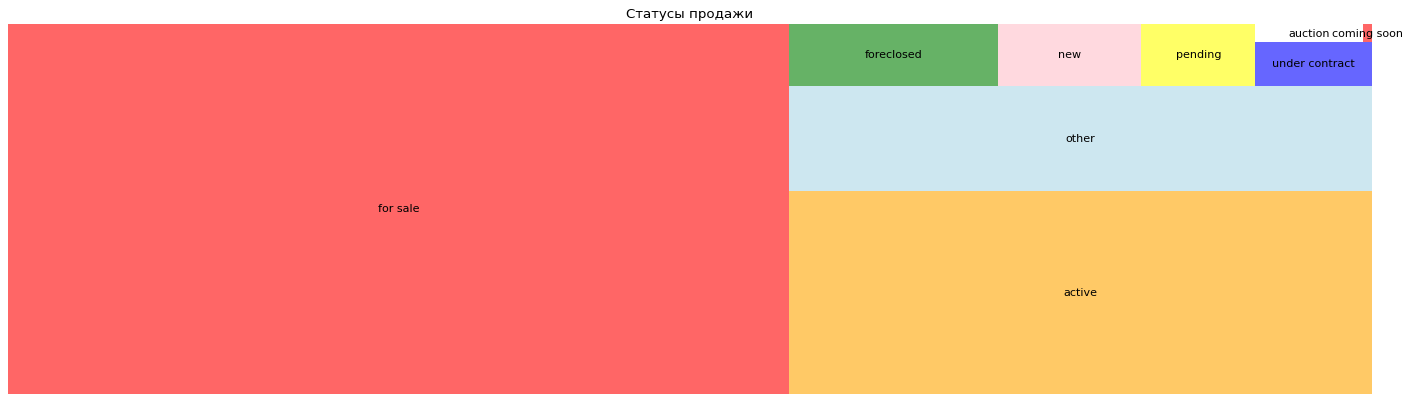

In [563]:
# визуализируем распределение недвижимости по статусу продажи
data_status = data.groupby('status')['status'].value_counts()
data_status = data_status.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением статусов продажи
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_status.values, label = data_status.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Статусы продажи')
plt.axis('off')
plt.show()

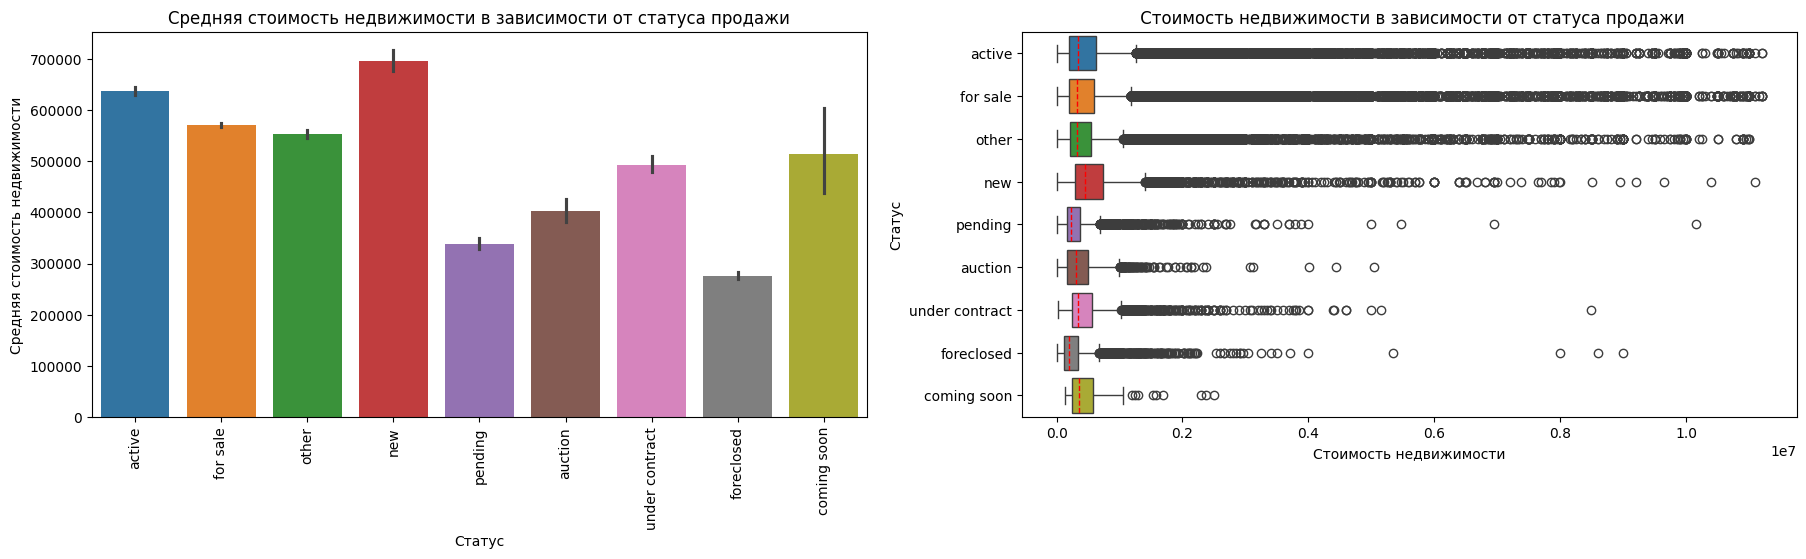

In [564]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от статуса продажи
sns.barplot(
            data, 
            x='status', 
            y='target', 
            hue='status', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Статус', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от статуса продажи')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от статуса продажи
sns.boxplot(
            data, 
            x='target', 
            y='status', 
            orient='h', 
            hue='status',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Статус')
axes[1].set_title(' Стоимость недвижимости в зависимости от статуса продажи')

plt.show()

Большинство объектов находятся в статусе for sale и active, что скорее всего значит одно и тоже. Средняя стоимость выше у новых объектов, самая низкая у объектов, лишенных права выкупа. Статус объекта влияет на его цену, которая может отличаться в 2 раза в зависимости от статуса.

In [565]:
encoder = ce.OneHotEncoder(cols = ['status'], use_cat_names=True)
status_bin = encoder.fit_transform(data['status'])
data = pd.concat([data, status_bin], axis=1)

In [566]:
data = data.drop('status', axis = 1)

#### 3.9 Признак propertyType - тип объекта недвижимости.

In [567]:
# выведем статистику
data['propertyType'].describe()

count                 310283
unique                  1075
top       single-family home
freq                   89590
Name: propertyType, dtype: object

In [568]:
# посмотрим на распределение
data['propertyType'].value_counts().nlargest(15)

propertyType
single-family home               89590
Single Family                    61146
Single Family Home               31015
condo                            25640
lot/land                         18657
Condo                            16007
townhouse                        11286
Condo/Townhome/Row Home/Co-Op     7478
Townhouse                         6794
multi-family                      6493
Traditional                       4342
coop                              2718
Multi Family                      2050
mobile/manufactured               1606
High Rise                         1547
Name: count, dtype: int64

In [569]:
data['propertyType'].isnull().mean()*100

8.311515617150793

In [570]:
data['propertyType'].unique().tolist()

['Single Family Home',
 'single-family home',
 'townhouse',
 'Florida',
 nan,
 'Single Family',
 'coop',
 'English',
 '2 Story',
 'Townhouse',
 'multi-family',
 'Multi-Family Home',
 'Condo',
 'condo',
 'lot/land',
 ' ',
 'Detached, Two Story',
 'Other Style',
 'Colonial',
 'Transitional',
 'High Rise',
 'mobile/manufactured',
 'Tri-Level, Northwestern Contemporary',
 'Condo/Townhome/Row Home/Co-Op',
 'Detached, One Story',
 'Craftsman',
 'Single Detached, French',
 'Single Detached, Traditional',
 '1 Story, Traditional',
 'Federal',
 'Multi Family',
 'Traditional',
 'Custom',
 'Cooperative',
 'Cape Cod, Contemporary, Florida, Key West',
 'Mobile / Manufactured',
 'Contemporary/Modern',
 'Miscellaneous',
 'Mfd/Mobile Home',
 'Bungalow',
 '1 Story',
 'Spanish/Mediterranean',
 'Contemporary',
 'Multi-Level, Modern',
 'Condo/Unit',
 '2 Stories, Traditional',
 'Ranch',
 'Low-Rise (1-3 Stories)',
 '1 Story, Contemporary',
 'Bungalow, Cape Cod',
 'Single Detached',
 'Urban Contemporary',
 '2

Как и в предыдущих признаках большое количество уникальных значений в призаке propertyType объясняется тем, что одна и таже информация записана в разном формате. Систематизируем ее, уменьшим количество значений, пропуски заменим на моду и закодируем признак.

In [571]:
data['propertyType'] = data['propertyType'].str.lower()

In [572]:
def get_property_type(property_type):
    str_property_type = str(property_type)
    for type in str_property_type:
        if property_type is np.nan:
            return np.nan
        elif 'detached' in str_property_type:
            return 'detached'
        elif 'single-family' in str_property_type or 'single family' in str_property_type:
            return 'single-family'
        elif 'multi-family' in str_property_type or 'multi family' in str_property_type:
            return 'multi-family'
        elif 'condo' in str_property_type:
            return 'condo'
        elif 'lot' in str_property_type:
            return 'lot'
        elif 'townhouse' in str_property_type:
            return 'townhouse'
        else:
            return 'other'

In [573]:
data['propertyType'] = data['propertyType'].apply(get_property_type)

In [574]:
data['propertyType'] = data['propertyType'].fillna(data['propertyType'].mode()[0])

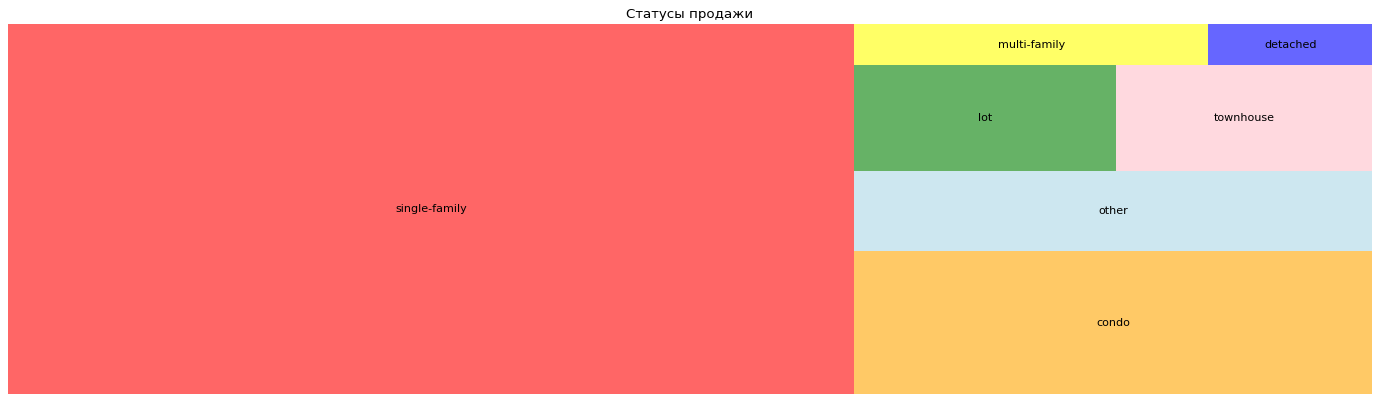

In [575]:
# визуализируем распределение недвижимости по типу недвижимости
data_propertyType = data.groupby('propertyType')['propertyType'].value_counts()
data_propertyType = data_propertyType.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением статусов продажи
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_propertyType.values, label = data_propertyType.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Статусы продажи')
plt.axis('off')
plt.show()

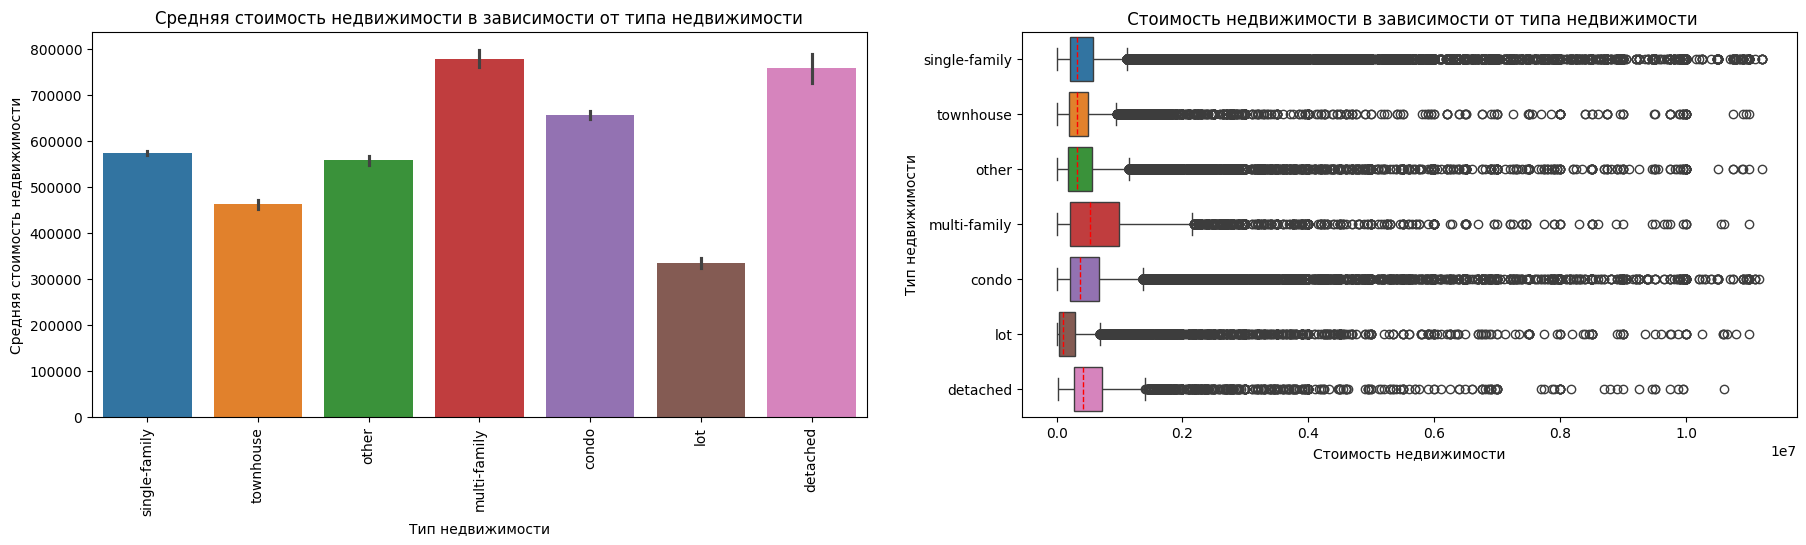

In [576]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа недвижимости
sns.barplot(
            data, 
            x='propertyType', 
            y='target', 
            hue='propertyType', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип недвижимости', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа недвижимости')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа недвижимости
sns.boxplot(
            data, 
            x='target', 
            y='propertyType', 
            orient='h', 
            hue='propertyType',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип недвижимости')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа недвижимости')

plt.show()

Наивысшая средняя стоимость у отдельно стоящей недвижимости (что неудевительно) и недвижимости, расположенной в многоквартирном доме (это неожиданно). Медианная цена также немного выше в этих двух категориях. Тип недвижимости влияет на ее стоимость, но большинство категорий не имеет сильной разницы в цене.

In [577]:
encoder = ce.OneHotEncoder(cols = ['propertyType'], use_cat_names=True)
propertyType_bin = encoder.fit_transform(data['propertyType'])
data = pd.concat([data, propertyType_bin], axis=1)

In [578]:
data = data.drop('propertyType', axis = 1)

In [579]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       338410 non-null  float64
 1   homeFacts                   338410 non-null  object 
 2   schools                     338410 non-null  object 
 3   sqft                        338410 non-null  int32  
 4   beds                        338410 non-null  int32  
 5   target                      338410 non-null  float64
 6   street_ln                   338410 non-null  int64  
 7   street_ave                  338410 non-null  int64  
 8   street_st                   338410 non-null  int64  
 9   street_unkown               338410 non-null  int64  
 10  street_dr                   338410 non-null  int64  
 11  street_rd                   338410 non-null  int64  
 12  street_pl                   338410 non-null  int64  
 13  street_hl          

#### 3.10 Признак homeFacts - сведения о строительстве объекта.

In [580]:
# выведем статистику
data['homeFacts'].describe()

count                                                338410
unique                                               294179
top       {'atAGlanceFacts': [{'factValue': '', 'factLab...
freq                                                   6347
Name: homeFacts, dtype: object

In [581]:
# посмотрим на распределение
data['homeFacts'].value_counts().nlargest(15)

homeFacts
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                 6347
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}      3431
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '', 'factLabe

In [582]:
data['homeFacts'].isnull().mean()*100

0.0

Признак homeFacts состоит из словаря со сведениями об объекте:

 - год постройки
 - год реконструкции
 - отопление
 - кондиционирование
 - парковка
 - размер участка
 - цена за кв.фут
 
Выделим каждый из фактов в отдельный признак и обработаем их.

In [583]:
new_home_facts_cols = ['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize', 'price/sqft']

for index, col in enumerate(new_home_facts_cols):
    data[col] = data['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))

Признак Price/sqft - цена за кв. фут является утечкой данных, поэтому его удаляем сразу. И признак homeFacts так же удаляем, всю информацию из него мы получили.

In [584]:
data = data.drop(['homeFacts', 'price/sqft'], axis = 1)

In [585]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       338410 non-null  float64
 1   schools                     338410 non-null  object 
 2   sqft                        338410 non-null  int32  
 3   beds                        338410 non-null  int32  
 4   target                      338410 non-null  float64
 5   street_ln                   338410 non-null  int64  
 6   street_ave                  338410 non-null  int64  
 7   street_st                   338410 non-null  int64  
 8   street_unkown               338410 non-null  int64  
 9   street_dr                   338410 non-null  int64  
 10  street_rd                   338410 non-null  int64  
 11  street_pl                   338410 non-null  int64  
 12  street_hl                   338410 non-null  int64  
 13  street_blw         

#### 3.10.1 Признак year built - год постройки.

In [586]:
# выведем статистику
data['year_built'].describe()

count     334977
unique       225
top             
freq       44021
Name: year_built, dtype: object

In [587]:
# посмотрим на распределение
data['year_built'].value_counts().nlargest(15)

year_built
        44021
2019    29775
2006     7528
2005     7064
2007     6715
2018     6424
2004     5183
2017     4836
2016     4706
2008     4692
1950     4253
2003     4247
2002     4023
1920     4004
2001     3922
Name: count, dtype: int64

In [588]:
data['year_built'].isnull().mean()*100

1.0144499276026122

In [589]:
data['year_built'].sort_values().unique()

array(['', '1', '1057', '1060', '1208', '1700', '1703', '1735', '1750',
       '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1803',
       '1804', '1805', '1807', '1808', '1809', '1810', '1812', '1815',
       '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825',
       '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836',
       '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848',
       '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857',
       '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865',
       '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873',
       '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881',
       '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889',
       '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897',
       '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
     

Предположим, что года 1057 и 1060 это ошибка и должны быть 1957 и 1960, заменим их.
Значения 1, 1208, 559990649990 и пустые заменим на np.nan

In [590]:
data.loc[data['year_built']=='1057','year_built'] = '1957'
data.loc[data['year_built']=='1060','year_built'] = '1960'
data['year_built'] = data['year_built'].apply(lambda x: np.nan if  x == '' or x ==  '1' or x == '1208' or x == '559990649990' or x== 'No Data' or x == None else x)

In [591]:
data['year_built'].isnull().mean()*100

14.340592772081203

После преобразований количество пропусков выросло, заменим их на моду и переведем признак в числовой тип.

In [592]:
data['year_built'] = data['year_built'].fillna(data['year_built'].mode()[0])
data['year_built'] = data['year_built'].astype(int)

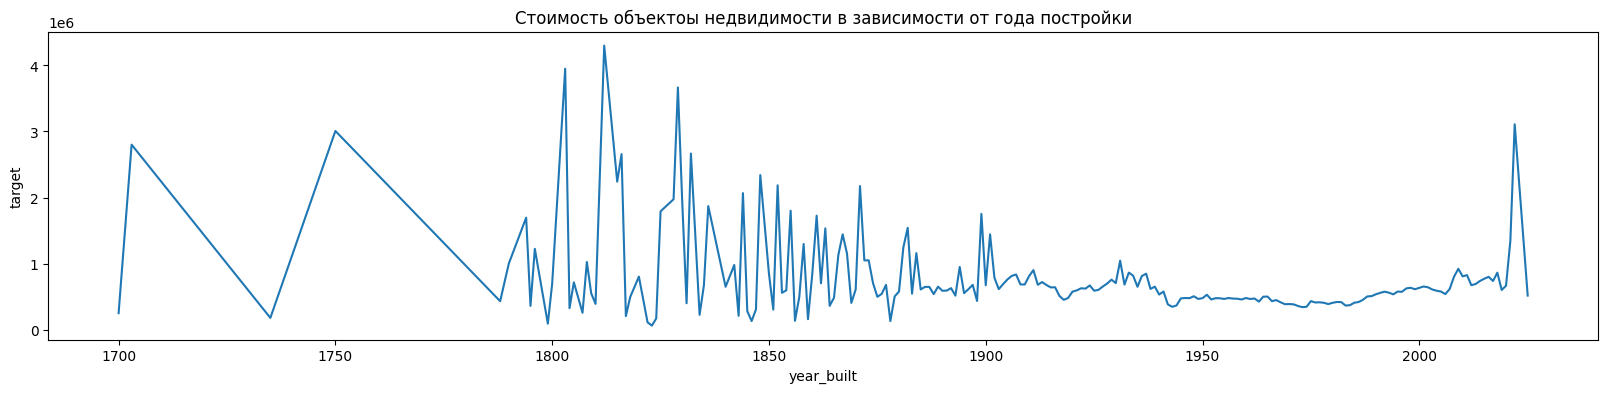

In [593]:
# визуализируем зависимость цены от года постройки
year_built_data = data.groupby('year_built', as_index = False)['target'].mean()
fig = plt.figure(figsize = (20,4))
lineplot = sns.lineplot(data=year_built_data, x="year_built", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от года постройки');

Определенной зависимости стоимости недвижимости от года постройки не наблюдается. На объекты до 1900 года стоимость абсолютно разная. После 1950 наблюдается постепенное повышение стоимости и резкий всплеск в районе 2020 года.

#### 3.10.2 Признак remodeled_year - год реконструкции.

In [594]:
# выведем статистику
data['remodeled_year'].describe()

count     313163
unique       152
top             
freq      171725
Name: remodeled_year, dtype: object

In [595]:
# посмотрим на распределение
data['remodeled_year'].value_counts().nlargest(15)

remodeled_year
        171725
2006      5219
2005      4557
2007      4145
2008      3559
2004      3186
1980      3089
1970      2915
2000      2862
1985      2655
2003      2648
2002      2575
1975      2532
1990      2483
1965      2455
Name: count, dtype: int64

In [596]:
data['remodeled_year'].isnull().mean()*100

7.460476936260749

Не смотря на то, что пропусков только 7%, более половины значение пустые. Этот признак удалим.

In [597]:
data = data.drop('remodeled_year', axis = 1)

#### 3.10.3 Признак heating - отопление.

In [598]:
# выведем статистику
data['heating'].describe()

count     334978
unique      1688
top             
freq       82790
Name: heating, dtype: object

In [599]:
# посмотрим на распределение
data['heating'].value_counts().nlargest(15)

heating
                     82790
Forced Air           80474
Forced air           50109
Other                28451
Electric              9373
Gas                   8999
No Data               7966
Central Air           6694
Heat Pump             5979
Central Electric      5973
Central               5115
Central, Electric     3962
Baseboard             3631
Wall                  3116
Heat pump             2710
Name: count, dtype: int64

In [600]:
data['heating'].isnull().mean()*100

1.0141544280606365

In [601]:
data['heating'].sort_values().unique().tolist()

['',
 ' Apply',
 ', Ceiling Heating, Hot Water, Radiator',
 ', Ductless/Mini-Split System, Gas Hot Air/Furnace',
 ', Ductless/Mini-Split System, Heat Pump - Heat, MultiZone Heat',
 ', Electric Baseboard Heat',
 ', Electric Baseboard Heat, Gas Hot Air/Furnace, Natural Gas',
 ', Electric Baseboard Heat, Heat Pump - Heat',
 ', Electric Hot Air',
 ', Electric Hot Air, Gas Floor Furnace, Gas Water Heater',
 ', Electric Hot Air, Gas Floor Furnace, Heat Pump - Heat, Natural Gas',
 ', Electric Hot Air, Gas Hot Air/Furnace',
 ', Electric Hot Air, Gas Hot Air/Furnace, Heat Pump - Heat, MultiZone Heat, Natural Gas',
 ', Electric Hot Air, Gas Water Heater',
 ', Electric Hot Air, Gas Water Heater, Heat Pump - Heat',
 ', Electric Hot Air, Gas Water Heater, Natural Gas',
 ', Electric Hot Air, Heat Pump - Heat',
 ', Electric Hot Air, Heat Pump - Heat, MultiZone Heat',
 ', Electric Hot Air, Heat Pump - Heat, Natural Gas',
 ', Electric Hot Air, Heat Pump - Heat, Propane, Woodstove',
 ', Electric Hot Air

Очень много разной иногда подроной иногда краткой информации об отоплении. Сократим количество значений, пропуски заменим модой, закодируем признак.

In [602]:
data['beds'] = data['beds'].apply(lambda x: str(x).replace('.', '') if  str(x).endswith('.') else x)

In [603]:
data['heating'] = data['heating'].str.lower()
data['heating'] = data['heating'].apply(lambda x: str(x).replace(',', ''))
data['heating'] = data['heating'].apply(lambda x: np.nan if  x == '' or x == None else x)

In [604]:
data['heating'].isnull().mean()*100

24.464407080169025

Пропусков много, но не достаточно, чтобы удалить весь признак, заменим их на 'unkown'.

In [605]:
data['heating'] = data['heating'].fillna('unkown')

In [606]:
data['heating'].value_counts().nlargest(15)

heating
forced air          130583
unkown               82790
other                28451
central electric      9935
electric              9374
gas                   9002
heat pump             8689
no data               7966
central air           6694
central               5115
baseboard             3631
None                  3432
wall                  3116
heating system        2686
electric heat         2292
Name: count, dtype: int64

Выделим 10 самых популярных типов отопления, остальные заменим на 'other'.

In [610]:
popular_heating = data['heating'].value_counts().nlargest(10)
data['heating'] = data['heating'].apply(lambda x: x if x in popular_heating else 'other')

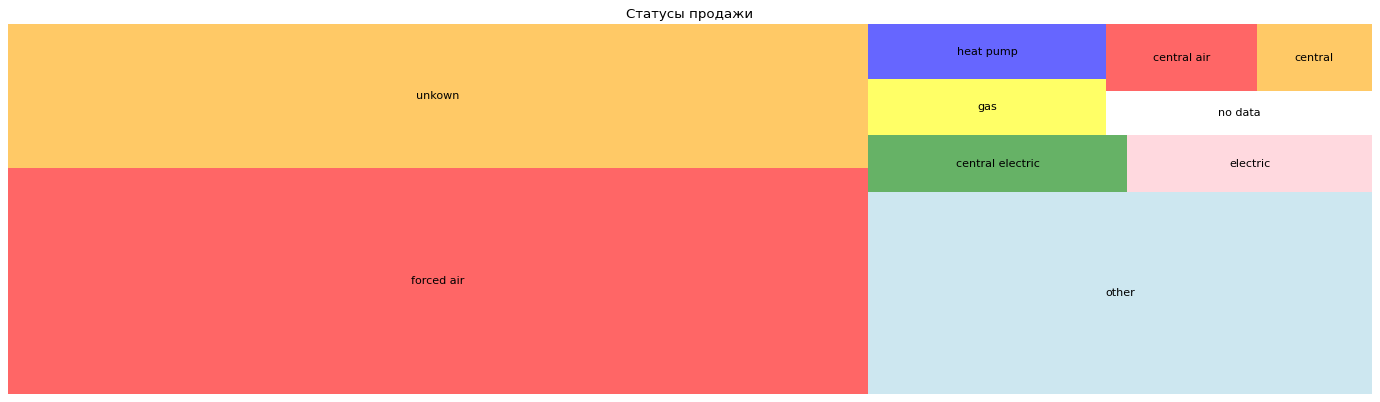

In [611]:
# визуализируем распределение недвижимости по типу отопления
data_heating = data.groupby('heating')['heating'].value_counts()
data_heating = data_heating.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением типов отопления
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_heating.values, label = data_heating.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Статусы продажи')
plt.axis('off')
plt.show()

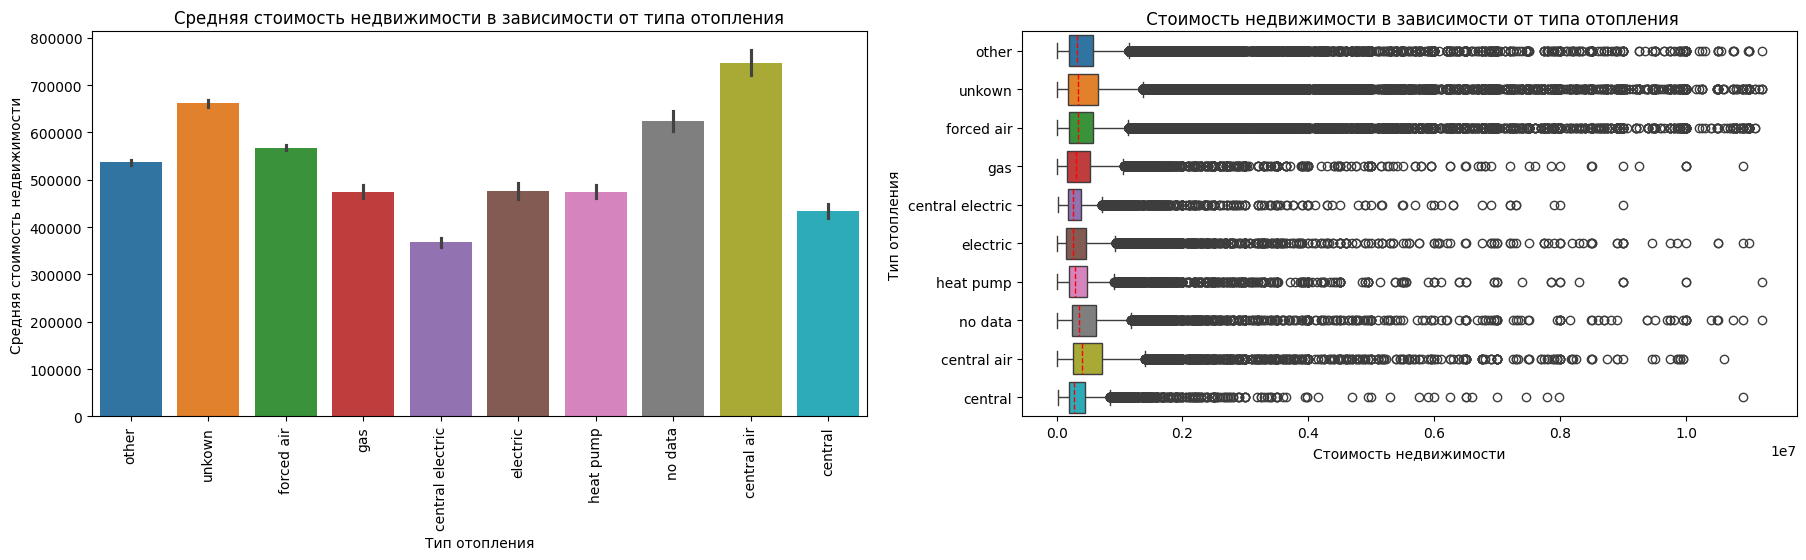

In [612]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа отопления
sns.barplot(
            data, 
            x='heating', 
            y='target', 
            hue='heating', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип отопления', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа отопления')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа отопления
sns.boxplot(
            data, 
            x='target', 
            y='heating', 
            orient='h', 
            hue='heating',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип отопления')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа отопления')

plt.show()

Самая высокая средняя цена у объектов с типом отопления central air, самая низкая - central electric (возможно помтоу что электричество - самый дорогой вид топлива). Различие медианной цены не сильные. Из-за того, что скорее всего одни и теже типы отопления записаны в разных форматах достаточно сложно интерпретировать этот признак. Можно отметить, что средняя стоимость зависит от типа отопления.

In [613]:
encoder = ce.OneHotEncoder(cols = ['heating'], use_cat_names=True)
heating_bin = encoder.fit_transform(data['heating'])
data = pd.concat([data, heating_bin], axis=1)

In [614]:
data = data.drop('heating', axis = 1)

#### 3.10.4 Признак cooling - кондиционирование.

In [615]:
# выведем статистику
data['cooling'].describe()

count      334978
unique       1261
top       Central
freq       155401
Name: cooling, dtype: object

In [616]:
# посмотрим на распределение
data['cooling'].value_counts().nlargest(15)

cooling
Central              155401
                      97414
Central Air           12702
No Data                9879
Has Cooling            8335
None                   7048
Central Electric       5806
Wall                   3777
Central Gas            2750
Cooling System         2679
Central A/C            1955
Other                  1668
Central Heating        1595
Refrigeration          1057
Central, Electric      1055
Name: count, dtype: int64

In [617]:
data['cooling'].isnull().mean()*100

1.0141544280606365

In [618]:
data['cooling'].sort_values().unique().tolist()

['',
 ' Apply',
 ', Central A/C',
 ', Gas Hot Air/Furnace',
 ', Gas Hot Air/Furnace, Heat Pump - AC, Natural Gas',
 ', Heat Pump - AC',
 ', Multizone A/C',
 ', Other',
 ', Wall Unit - AC',
 ', Window Unit',
 ', Window Unit(s)',
 '1',
 '1 (Window/Wall Unit)',
 '1 Unit',
 '1 Unit, Baseboard - Cast Iron, Multi-Zone',
 '1 Unit, Baseboard - Hotwater',
 '1 Unit, Baseboard - Hotwater, Multi-Zone',
 '1 Unit, Ceiling Fan, Central Air',
 '1 Unit, Central',
 '1 Unit, Central Air',
 '1 Unit, Central Air, Multi-Zone Cooling',
 '1 Unit, Central Heating',
 '1 Unit, Multi-Zone Cooling, Central Air',
 '2',
 '2 (Window/Wall Unit)',
 '2 Air Conditioners',
 '2 Units',
 '2 Units, Central AC',
 '2 Units, Central AC, Zoned',
 '2 Units, Forced Hot Air',
 '2 Units, Forced Hot Air, Multi-Zone',
 '2 or More Units',
 '2 or More Units, Central',
 '2 or More Units, Central, Electric',
 '2 or More Units, Central, Electric, Whole House Fan',
 '2 or More Units, Central, Electric, Window Unit',
 '2 or More Units, Centr

### 4. Решение задачи регрессии.

In [456]:
#sns.pairplot(data)

#### 4.1 Линейная регрессия.

#### 4.2 Дерево решений.

#### 4.3 Случайный лес

#### 4.3 Градиентыный бустинг

#### 4.3 Cat бустинг